DECISION TREE
Nel file preprocessing_for_adult.py sono contenute le funzioni per il preprocessing da applicare ad adult.data: la prima (preprocessing_funct_not_enc) discretizza, normalizza ecc mentre la seconda (encoding_funct) esegue l'encoding.

In [477]:
from preprocessing_for_adult import preprocessing_funct_not_enc, encoding_funct, K_subgroups_dataset_and_and, K_subgroups_dataset_and_or, metrics_to_compare, preprocessing_funct_not_enc_SMOTE, encoding_funct_SMOTE
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
import torch


from divexplorer import DivergenceExplorer
from divexplorer import DivergencePatternProcessor
from divexplorer.outcomes import get_false_positive_rate_outcome


In [478]:
torch.manual_seed(42)
seed = 42
pd.options.display.float_format = '{:.3f}'.format

In [479]:
min_sup = 0.2
percentage = 25


In [480]:
col_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
                'marital-status', 'occupation', 'relationship', 'race', 'sex',
                'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
df = pd.read_csv("adult.data", header = None, names = col_names)

In [481]:
df_train, df_val, df_test, df_holdout = preprocessing_funct_not_enc(df)
#controllo divisione dataset
print(f"TRAIN SET ROWS: ", df_train.shape[0]) #su 32536, il 40%  dovrebbe essere circa 13014
print(f"VALIDATION SET ROWS: ", df_val.shape[0]) #su 32536, il 20%  dovrebbe essere circa 6500
print(f"HOLDOUT SET ROWS: ", df_holdout.shape[0])
print(f"TEST SET ROWS: ", df_test.shape[0])

TRAIN SET ROWS:  13014
VALIDATION SET ROWS:  6507
HOLDOUT SET ROWS:  6508
TEST SET ROWS:  6508


In [482]:
df_train_enc, df_test_enc, df_holdout_enc, df_val_enc = encoding_funct(df_train=df_train, df_test=df_test, df_holdout=df_holdout, df_val=df_val)
#controllo coerenza con numerosità precedente
print(f"TRAIN SET ROWS: ", df_train_enc.shape[0]) #su 32536, il 40%  dovrebbe essere circa 13014
print(f"VALIDATION SET ROWS: ", df_val_enc.shape[0]) #su 32536, il 20%  dovrebbe essere circa 6500
print(f"HOLDOUT SET ROWS: ", df_holdout_enc.shape[0])
print(f"TEST SET ROWS: ", df_test_enc.shape[0])

TRAIN SET ROWS:  13014
VALIDATION SET ROWS:  6507
HOLDOUT SET ROWS:  6508
TEST SET ROWS:  6508


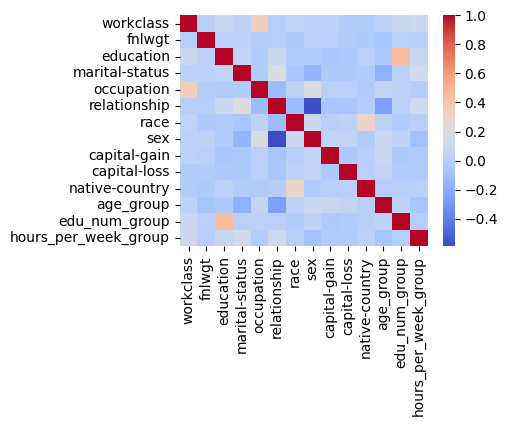

In [483]:
df_train_no_income = df_train_enc.drop(columns = 'income')
plt.figure(figsize=(4, 3))
g = sns.heatmap(df_train_no_income.corr(),
                annot = False,
                cmap = "coolwarm")


In [484]:
#DECISION TREE CLASSIFIER
X_train = df_train_enc.drop(columns = 'income', axis = 1)
y_train = df_train_enc['income']

X_test = df_test_enc.drop(columns = 'income', axis = 1)
y_test = df_test_enc['income']

X_val = df_val_enc.drop(columns = 'income', axis = 1)
y_val = df_val_enc['income']

X_holdout = df_holdout_enc.drop(columns = 'income', axis = 1)
y_holdout = df_holdout_enc['income']

classifier_train = DecisionTreeClassifier(random_state=seed)
classifier_train.fit(X_train, y_train)
y_pred = classifier_train.predict(X_test)
cm_classifier = confusion_matrix(y_test, y_pred)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm_classifier, display_labels=[False, True])
#disp.plot()
#plt.show()


In [485]:
accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before = metrics_to_compare(y_true = y_test, y_pred = y_pred )
metrics_before_df = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Test Size'],
    'Before Mitigation': [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_test)],
})
metrics_before_df = metrics_before_df.set_index('Metrics').T

metrics_to_cast = ['False Positives', 'False Negatives', 'Test Size']

for metric in metrics_to_cast:
    metrics_before_df[metric] = metrics_before_df[metric].astype(int)

metrics_before_df

Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Test Size
Before Mitigation,0.803,0.593,0.130,0.407,641,638,6508


SUBGROUPS SEARCH

-Identifico i gruppi applicando DivExplorer sul validation not encoded (a cui ho aggiunto la feature sui falsi positivi da passare a boolean outcomes e la feature accuracy che vale 1 se la predizione è giusta e 0 se sbagliata )

-Integro nel training set dati che matchano sottogruppi problematici prendendoli dall'holdout, (primi K = 5, tutte le righe holdout che matchano)

-Ripeto training e test

In [486]:
#predizioni per il validation set, queste mi servono solo per il div explorer che ha bisogno di ground truth e predizioni
y_pred_val = classifier_train.predict(X_val)

df_val_class = X_val.copy()
df_val_class['y_val_true'] = y_val
df_val_class['y_pred'] = y_pred_val

df_val_class.head()

,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,native-country,age_group,edu_num_group,hours_per_week_group,y_val_true,y_pred
18761,2,0.077,3,0,4,1,4,0,0.000,0.000,5,2,1,1,0,0
27582,3,0.048,3,1,4,0,4,1,0.000,0.000,5,5,1,2,1,0
30911,2,0.174,3,3,4,4,2,0,0.039,0.000,5,1,1,1,0,0
11128,0,0.012,2,1,2,0,2,1,0.000,0.507,5,3,4,1,1,1
683,0,0.284,3,3,2,4,2,1,0.000,0.000,5,0,1,1,0,0


In [487]:
y_trues = df_val_class["y_val_true"]
y_preds = df_val_class["y_pred"]

df_val_class['fp'] =  get_false_positive_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fp' a df_val non encoded
df_val['fp'] = df_val_class['fp']

#aggiungo la feature accuracy a df_val non encoded che assume valore 1 se la predizione è giusta 0 se la predizione è sbagliata
#come controllo che sia corretto aggiungo la feature y_pred 
df_val['y_pred'] = df_val_class['y_pred'] 
df_val['accuracy'] = (df_val_class['y_val_true']==df_val_class['y_pred']).astype(int)
df_val.head()


,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,native-country,income,age_group,edu_num_group,hours_per_week_group,fp,y_pred,accuracy
18761,Private,0.077,Non Graduated,Divorced,Self-emp-occ,Not-in-family,White,Female,0.000,0.000,United-States,0,35-44,10 College,Overtime,0.000,0,1
27582,Self-emp,0.048,Non Graduated,Married,Self-emp-occ,Husband,White,Male,0.000,0.000,United-States,1,65-100,10 College,Part-time,NaN,0,0
30911,Private,0.174,Non Graduated,Separated,Self-emp-occ,Unmarried,Black,Female,0.039,0.000,United-States,0,25-34,10 College,Overtime,0.000,0,1
11128,Government,0.012,Master's Degree,Married,Private-occ,Husband,Black,Male,0.000,0.507,United-States,1,45-54,14 Master's Degree,Overtime,NaN,1,1
683,Government,0.284,Non Graduated,Separated,Private-occ,Unmarried,Black,Male,0.000,0.000,United-States,0,17-24,10 College,Overtime,0.000,0,1


ANALISI CONDOTTA CON LA FEATURE FP (PASSATA A BOOLEAN OUTCOME)

In [488]:
fp_diver = DivergenceExplorer(df_val)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
FP_fm = FP_fm.sort_values(by=["fp_div", "fp_t"], ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
FP_fm.head()

,support,itemset,fp,fp_div,fp_t,length,support_count
0,0.239,"(capital-gain=0.0, capital-loss=0.0, sex= Male, hours_per_week_group=Overtime, relationship= Husband, race= White, marital-status=Married, native-country=United-States)",0.362,0.224,13.300,8,1554.000
1,0.239,"(capital-gain=0.0, capital-loss=0.0, sex= Male, hours_per_week_group=Overtime, relationship= Husband, race= White, native-country=United-States)",0.362,0.224,13.300,7,1554.000
2,0.239,"(capital-gain=0.0, capital-loss=0.0, hours_per_week_group=Overtime, relationship= Husband, race= White, marital-status=Married, native-country=United-States)",0.362,0.224,13.300,7,1554.000
3,0.239,"(capital-gain=0.0, capital-loss=0.0, hours_per_week_group=Overtime, relationship= Husband, race= White, native-country=United-States)",0.362,0.224,13.300,6,1554.000
4,0.259,"(capital-gain=0.0, sex= Male, hours_per_week_group=Overtime, relationship= Husband, race= White, native-country=United-States)",0.361,0.223,13.527,6,1686.000


In [489]:
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fp')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)
df_pruned_fp.head()

,support,itemset,length,support_count,fp,fp_div,fp_t
16,0.297,"(race= White, hours_per_week_group=Overtime, relationship= Husband, native-country=United-States)",4,1931.000,0.353,0.214,13.450
28,0.326,"(race= White, hours_per_week_group=Overtime, marital-status=Married, native-country=United-States)",4,2124.000,0.349,0.211,13.859
69,0.353,"(marital-status=Married, hours_per_week_group=Overtime, native-country=United-States)",3,2299.000,0.339,0.201,13.841
84,0.356,"(hours_per_week_group=Overtime, relationship= Husband)",2,2318.000,0.335,0.196,13.694
138,0.401,"(marital-status=Married, hours_per_week_group=Overtime)",2,2612.000,0.325,0.186,13.881


In [490]:
# Numero totale di istanze
total_instances = len(df_pruned_fp)

# Numero di istanze con fp_div > 0 e fp_t > 2
filtered_instances = len(df_pruned_fp[(df_pruned_fp['fp_div'] > 0) & (df_pruned_fp['fp_t'] > 2)])

print('total subgroups', total_instances)
print('total problematic', filtered_instances)

total subgroups 58
total problematic 34


In [491]:
prun_size = df_pruned_fp.shape
original_size = FP_fm.shape
print("Dim original: ", original_size)
print("Dim pruned th_redundancy ", prun_size)


Dim original:  (893, 7)
Dim pruned th_redundancy  (58, 7)


In [492]:
K = int((percentage / 100) * filtered_instances)
K

8

BIAS MITIGATION: ADDING DATA: prendo dati dall'hold-out e li aggiungo al train set, questi dati matchano gli itemset trovati prima (i primi 5)

1. prendo dati dall'holdout con la funzione K_subgroups_dataset_and_or li aggiungo train 
2. riapplico encoding tutto
3. Decision tree nuovamente e vedo come sono cambiate le performance (ad es Accuracy, false positive rate, false negative rate) overall e per sottogruppi

In [493]:
df_holdout_filtered = K_subgroups_dataset_and_or(df_pruned_fp, df_holdout, K) #da aggiungere a train set e ripetere train e test
df_holdout_filtered_solo0 = df_holdout_filtered[df_holdout_filtered['income']==0]



df_combinated = pd.concat([df_holdout_filtered_solo0, df_train], ignore_index=True)
df_train_mitigated= df_combinated.sample(frac=1, random_state=seed).reset_index(drop=True)

df_holdout_filtered = df_holdout_filtered_solo0 


In [494]:
print(len(df_holdout_filtered))

1715


In [495]:
'''#riapplico funzione di encoding, ma al posto di holdout, uso il df filtrato che devo usare per inserire dati 
df_train_enc_mit, df_test_enc_filtered_fp, df_filtered_enc, df_val_enc_mit = encoding_funct(df_train=df_train_mitigated, df_test=df_test_filtered_fp, df_holdout=df_holdout_filtered, df_val=df_val)
#controllo divisione dataset
df_train_enc_mit_fp = df_train_enc_mit  
print(f"TRAIN SET ROWS: ", df_train_enc.shape[0])
print(f"TRAIN SET MITIGATED ROWS: ", df_train_enc_mit.shape[0]) #su 32536, il 40%  dovrebbe essere circa 13014
print(f"VALIDATION SET ROWS: ", df_val_enc_mit.shape[0]) #su 32536, il 20%  dovrebbe essere circa 6500
print(f"FILTERED DF holdout ROWS: ", df_filtered_enc.shape[0])
print(f"TEST SET FILTERED ROWS: ", df_test_enc_filtered_fp.shape[0])'''

'#riapplico funzione di encoding, ma al posto di holdout, uso il df filtrato che devo usare per inserire dati \ndf_train_enc_mit, df_test_enc_filtered_fp, df_filtered_enc, df_val_enc_mit = encoding_funct(df_train=df_train_mitigated, df_test=df_test_filtered_fp, df_holdout=df_holdout_filtered, df_val=df_val)\n#controllo divisione dataset\ndf_train_enc_mit_fp = df_train_enc_mit  \nprint(f"TRAIN SET ROWS: ", df_train_enc.shape[0])\nprint(f"TRAIN SET MITIGATED ROWS: ", df_train_enc_mit.shape[0]) #su 32536, il 40%  dovrebbe essere circa 13014\nprint(f"VALIDATION SET ROWS: ", df_val_enc_mit.shape[0]) #su 32536, il 20%  dovrebbe essere circa 6500\nprint(f"FILTERED DF holdout ROWS: ", df_filtered_enc.shape[0])\nprint(f"TEST SET FILTERED ROWS: ", df_test_enc_filtered_fp.shape[0])'

In [496]:
#riapplico funzione di encoding, ma al posto di holdout, uso il df filtrato che devo usare per inserire dati 
df_train_enc_mit, inutile1, inutile3, inutile2 = encoding_funct(df_train=df_train_mitigated, df_test=df_test, df_holdout=df_holdout_filtered, df_val=df_val)
#controllo divisione dataset
df_train_enc_mit_fp = df_train_enc_mit  
print(f"TRAIN SET ROWS: ", df_train_enc.shape[0])
print(f"TRAIN SET MITIGATED ROWS: ", df_train_enc_mit.shape[0]) #su 32536, il 40%  dovrebbe essere circa 13014
print(f"VALIDATION SET ROWS: ", inutile1.shape[0]) #su 32536, il 20%  dovrebbe essere circa 6500
print(f"FILTERED DF holdout ROWS: ", inutile3.shape[0])
print(f"TEST SET FILTERED ROWS: ", inutile2.shape[0])

TRAIN SET ROWS:  13014
TRAIN SET MITIGATED ROWS:  14729
VALIDATION SET ROWS:  6508
FILTERED DF holdout ROWS:  1715
TEST SET FILTERED ROWS:  6507


In [497]:
X_train_mitigated = df_train_enc_mit.drop(columns = 'income', axis = 1)
y_train_mitigated = df_train_enc_mit['income']


classifier_train_mitigated = DecisionTreeClassifier(random_state=seed)

classifier_train_mitigated.fit(X_train_mitigated, y_train_mitigated)
y_mitigated_pred = classifier_train_mitigated.predict(X_test)
#cm_dt = confusion_matrix(y_test, y_mitigated_pred)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=[False, True])
#disp.plot()
#plt.show()

In [498]:
#per veriicare cosa accade se aggiungo in modo randomico lo stesso numero di righe al train, ripeto l'analisi facebdo mitigation con righe randomiche (uguali in numero)
print(len(df_holdout_filtered))
n = len(df_holdout_filtered)
df_holdout_sampled = df_holdout_enc.sample(n=len(df_holdout_filtered), replace=True, random_state=seed)
print("verifica :", len(df_holdout_sampled)) #verifica



df_combinated_random = pd.concat([df_holdout_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random= df_combinated_random.sample(frac=1, random_state=seed).reset_index(drop=True)

X_train_mitigated_random = df_train_mitigated_random.drop(columns="income", axis = 1)
y_train_mitigated_random = df_train_mitigated_random['income']

classifier_train_mitigated_random = DecisionTreeClassifier(random_state=seed)

classifier_train_mitigated_random.fit(X_train_mitigated_random, y_train_mitigated_random)
y_mitigated_pred_random = classifier_train_mitigated_random.predict(X_test)



1715
verifica : 1715


In [499]:
accuracy_fp_after, f1_score_fp_after, fpr_fp_after, fnr_fp_after, fp_fp_after, fn_fp_after = metrics_to_compare(y_true = y_test, y_pred = y_mitigated_pred )
accuracy_fp_after_random, f1_score_fp_after_random, fpr_fp_after_random, fnr_fp_after_random, fp_fp_after_random, fn_fp_after_random= metrics_to_compare(y_true = y_test, y_pred = y_mitigated_pred_random)

metrics_after_fp = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation' : [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After Mitigation(K=5, fp)': [accuracy_fp_after, f1_score_fp_after, fpr_fp_after, fnr_fp_after, fp_fp_after, fn_fp_after, len(y_train_mitigated), len(y_test)],
    'After RANDOM mitigation' : [accuracy_fp_after_random, f1_score_fp_after_random, fpr_fp_after_random, fnr_fp_after_random, fp_fp_after_random, fn_fp_after_random, len(y_train_mitigated_random), len(y_test)]
})
metrics_after_fp = metrics_after_fp.set_index('Metrics').T



metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']

for metric in metrics_to_cast:
    metrics_after_fp[metric] = metrics_after_fp[metric].astype(int)

metrics_after_fp

Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
Before Mitigation,0.803,0.593,0.130,0.407,641,638,13014,6508
"After Mitigation(K=5, fp)",0.816,0.599,0.106,0.430,522,674,14729,6508
After RANDOM mitigation,0.808,0.606,0.130,0.386,643,606,14729,6508


Performance su sottogruppi 


In [500]:
df_test_filtered_fp = K_subgroups_dataset_and_or(df_pruned_fp, df_test, K)
inutile, df_test_filtered_enc_fp, inutile2, inutile3 = encoding_funct(df_train, df_test_filtered_fp, df_holdout, df_val)

X_test_filtered_fp = df_test_filtered_enc_fp.drop(columns='income', axis = 1)
y_true_test_filtered_fp = df_test_filtered_enc_fp['income']

y_pred_test_filtered_fp_before = classifier_train.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after = classifier_train_mitigated.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_random = classifier_train_mitigated_random.predict(X_test_filtered_fp)

accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_before )
accuracy_fp_sottogruppi_after, f1_score_fp_sottogruppi_after, fpr_fp_sottogruppi_after, fnr_fp_sottogruppi_after, fp_fp_sottogruppi_after, fn_fp_sottogruppi_after = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after )
accuracy_fp_sottogruppi_after_random, f1_score_fp_sottogruppi_after_random, fpr_fp_sottogruppi_after_random, fnr_fp_sottogruppi_after_random, fp_fp_sottogruppi_after_random, fn_fp_sottogruppi_after_random = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_random)


metrics_after_fp_sottogruppi = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation, on subgroups' : [accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before, len(y_train), len(y_pred_test_filtered_fp_before)],
    'After Mitigation(K=5, on subgroups, fp)': [accuracy_fp_sottogruppi_after, f1_score_fp_sottogruppi_after, fpr_fp_sottogruppi_after, fnr_fp_sottogruppi_after, fp_fp_sottogruppi_after, fn_fp_sottogruppi_after, len(y_train_mitigated), len(y_pred_test_filtered_fp_after)],
    'After RANDOM Mitigation(K=5, on subgroups, fp)': [accuracy_fp_sottogruppi_after_random, f1_score_fp_sottogruppi_after_random, fpr_fp_sottogruppi_after_random, fnr_fp_sottogruppi_after_random, fp_fp_sottogruppi_after_random, fn_fp_sottogruppi_after_random, len(y_train_mitigated_random), len(y_pred_test_filtered_fp_after_random)]
})
metrics_after_fp_sottogruppi = metrics_after_fp_sottogruppi.set_index('Metrics').T

metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']

for metric in metrics_to_cast:
    metrics_after_fp_sottogruppi[metric] = metrics_after_fp_sottogruppi[metric].astype(int)

metrics_after_fp


print("Subgroups Decision Tree performance when boolean outcomes = fp")
metrics_after_fp_sottogruppi

Subgroups Decision Tree performance when boolean outcomes = fp


Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
"Before Mitigation, on subgroups",0.674,0.628,0.288,0.375,494,508,13014,3069
"After Mitigation(K=5, on subgroups, fp)",0.695,0.632,0.227,0.404,390,547,14729,3069
"After RANDOM Mitigation(K=5, on subgroups, fp)",0.682,0.641,0.289,0.356,496,481,14729,3069


ANALISI DIVERGENZE

Per vedere cosa accade ai sottogruppi: vedo cosa succede alle divergenze del test dopo la mitigation

In [501]:
#all'inizio sul test set senza nessuna mitigation
#prima per la baseline 1 che è quella che replica il metodo del paper 
#predizioni per il test set y_mitigated_pred 


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fp'] =  get_false_positive_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fp' a df_val non encoded
df_test['fp'] = df_test_class['fp']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fp')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)
df_pruned_fp.head()



fp_div_list_no_mitigation  = df_pruned_fp["fp_div"].tolist()
#fp_div_list_no_mitigation


In [502]:
#prima per la baseline 1 che è quella che replica il metodo del paper 
#predizioni per il test set y_mitigated_pred 


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_mitigated_pred 

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fp'] =  get_false_positive_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fp' a df_val non encoded
df_test['fp'] = df_test_class['fp']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fp')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)
df_pruned_fp.head()



fp_div_list_baseline1  = df_pruned_fp["fp_div"].tolist()
#fp_div_list_baseline1


In [503]:
#PER VEDERE COSA SUCCEDE ALLE DIVERGENZE DEI SOTTOGRUPPI CON MITIGATION RADOMICA
#prima per la baseline 1 che è quella che replica il metodo del paper 
#predizioni per il test set y_mitigated_pred 


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_mitigated_pred_random

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fp'] =  get_false_positive_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fp' a df_val non encoded
df_test['fp'] = df_test_class['fp']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fp')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)
df_pruned_fp.head()



fp_div_list_random  = df_pruned_fp["fp_div"].tolist()
#fp_div_list_random_per_confrontare_con_baseline1


In [504]:
# Calcolo delle medie e del massimo con valore assoluto solo dopo
media_fp_div_list_no_mitigation = abs(sum(fp_div_list_no_mitigation) / len(fp_div_list_no_mitigation))
media_fp_div_list_nomitigation_primi10 = abs(sum(fp_div_list_no_mitigation[:10]) / len(fp_div_list_no_mitigation[:10]))
media_fp_div_list_nomitigation_primi20 = abs(sum(fp_div_list_no_mitigation[:20]) / len(fp_div_list_no_mitigation[:20]))
media_fp_div_list_nomitigation_primi40 = abs(sum(fp_div_list_no_mitigation[:40]) / len(fp_div_list_no_mitigation[:40]))
massimo_valore_assoluto_fp_div_no_mitigation = max(abs(x) for x in fp_div_list_no_mitigation)

media_fp_div_list_baseline1 = abs(sum(fp_div_list_baseline1) / len(fp_div_list_baseline1))
media_fp_div_list_baseline1_primi10 = abs(sum(fp_div_list_baseline1[:10]) / len(fp_div_list_baseline1[:10]))
media_fp_div_list_baseline1_primi20 = abs(sum(fp_div_list_baseline1[:20]) / len(fp_div_list_baseline1[:20]))
media_fp_div_list_baseline1_primi40 = abs(sum(fp_div_list_baseline1[:40]) / len(fp_div_list_baseline1[:40]))
fp_div_massimo_valore_assoluto_fp_div_baseline1 = max(abs(x) for x in fp_div_list_baseline1)

media_fp_div_list_random_per_confrontare_con_baseline1 = abs(sum(fp_div_list_random_per_confrontare_con_baseline1) / len(fp_div_list_random_per_confrontare_con_baseline1))
media_fp_div_list_random_per_confrontare_con_baseline1_primi10 = abs(sum(fp_div_list_random_per_confrontare_con_baseline1[:10]) / len(fp_div_list_random_per_confrontare_con_baseline1[:10]))
media_fp_div_list_random_per_confrontare_con_baseline1_primi20 = abs(sum(fp_div_list_random_per_confrontare_con_baseline1[:20]) / len(fp_div_list_random_per_confrontare_con_baseline1[:20]))
media_fp_div_list_random_per_confrontare_con_baseline1_primi40 = abs(sum(fp_div_list_random_per_confrontare_con_baseline1[:40]) / len(fp_div_list_random_per_confrontare_con_baseline1[:40]))
massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1 = max(abs(x) for x in fp_div_list_random_per_confrontare_con_baseline1)

# Creazione del DataFrame finale
divergence_after_fp_sottogruppi = pd.DataFrame({
    'Metrics': [
        'Accuracy', 'F1 Score', 'media divergenze', 'max div', 'media div primi 10', 'media div primi 20', 'media div primi 40', '# new samples'
    ],
    'Before Mitigation': [
        accuracy_before, f1_score_before, media_fp_div_list_no_mitigation, massimo_valore_assoluto_fp_div_no_mitigation,
        media_fp_div_list_nomitigation_primi10, media_fp_div_list_nomitigation_primi20, media_fp_div_list_nomitigation_primi40, 0
    ],
    'After Mitigation(K=5 fp)': [
        accuracy_fp_after, f1_score_fp_after, media_fp_div_list_baseline1, fp_div_massimo_valore_assoluto_fp_div_baseline1,
        media_fp_div_list_baseline1_primi10, media_fp_div_list_baseline1_primi20, media_fp_div_list_baseline1_primi40, len(df_holdout_filtered)
    ],
    'After RANDOM Mitigation(K=5 fp)': [
        accuracy_fp_after_random, f1_score_fp_after_random, media_fp_div_list_random_per_confrontare_con_baseline1,
        massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1, media_fp_div_list_random_per_confrontare_con_baseline1_primi10,
        media_fp_div_list_random_per_confrontare_con_baseline1_primi20, media_fp_div_list_random_per_confrontare_con_baseline1_primi40,
        len(df_holdout_filtered)
    ]
})

# Trasposizione per visualizzazione
divergence_after_fp_sottogruppi = divergence_after_fp_sottogruppi.set_index('Metrics').T

divergence_after_fp_sottogruppi


Metrics,Accuracy,F1 Score,media divergenze,max div,media div primi 10,media div primi 20,media div primi 40,# new samples
Before Mitigation,0.803,0.593,0.054,0.190,0.172,0.153,0.097,0.000
After Mitigation(K=5 fp),0.816,0.599,0.013,0.136,0.094,0.061,0.020,1715.000
After RANDOM Mitigation(K=5 fp),0.808,0.606,0.024,0.168,0.138,0.091,0.036,1715.000


BIAS MITIGATION SIMULANDO DATI ATTRAVERSO SMOTE

SEGUE CODICE USANDO SMOTE 
DIVIDO IN TRAIN, TEST E VALIDATION -- ora uso quelli gia esistenti
DIV EXPLORER SUL VALIDATION  -- già fatto 
GENERO NUOVI DATI CON SMOTE a partire dai dati di divexplorer sul validation
INSERISCO QUESTI NUOVI DATI NEL TRAIN SET

In [505]:
from imblearn.over_sampling import SMOTENC
df_val_filtered = K_subgroups_dataset_and_or(df_pruned_fp, df_val, K)
print("Righe del dataset filtrato qunado K = 5",len(df_val_filtered))
#df_val_filtered.head() #var categoriche e numeriche 
#print(len(df_val_filtered)) #--2610 con = 5
df_val_filtered, inutile12, inutile222 = encoding_funct_SMOTE(df_val_filtered, df_test, df_holdout)
X_to_SMOTE =  df_val_filtered.drop(columns = ['fp', 'y_pred', 'accuracy', 'income'], axis = 1)
y_to_SMOTE = df_val_filtered['income']
X_to_SMOTE.head()

categorical_features = [0, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13]

smote_nc = SMOTENC( categorical_features=categorical_features, random_state=seed)
X_resampled, y_resampled = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)

print("numero di dati simulati con smotenc",len(y_resampled))

class_counts = y_resampled.value_counts()
print(class_counts)




Righe del dataset filtrato qunado K = 5 3063
numero di dati simulati con smotenc 3428
income
1    1714
0    1714
Name: count, dtype: int64


aggiungo una sampling strategy in modo da avere piu etichette = 0 visto che i sottogruppi porblematici hanno piu spesso etichette = 1 (per costruzione-per come ho impostato la ricerca dei sottogruppi)

In [506]:

'''sampling_strategy = {0: 2500, 1: 1400}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_resampled, y_resampled = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)

print(len(y_resampled))

class_counts = y_resampled.value_counts()
print(class_counts)
'''

'sampling_strategy = {0: 2500, 1: 1400}\n\nsmote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)\nX_resampled, y_resampled = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)\n\nprint(len(y_resampled))\n\nclass_counts = y_resampled.value_counts()\nprint(class_counts)\n'

In [507]:
X_train_mitigated_SMOTE = pd.concat([X_train, X_resampled], ignore_index=True)
y_train_mitigated_SMOTE = pd.concat([y_train, y_resampled], ignore_index=True)
print(len(X_train_mitigated_SMOTE))


16442


In [508]:
# X_test.head()  come verifica che tutto sia numerico 

In [509]:
classifier_train_mitigated_SMOTE = DecisionTreeClassifier(random_state=seed)
classifier_train_mitigated_SMOTE.fit(X_train_mitigated_SMOTE, y_train_mitigated_SMOTE)
y_mitigated_SMOTE_pred = classifier_train_mitigated_SMOTE.predict(X_test)

In [510]:
'''#vediamo che succede se prendo lo stesso numero di righe ma random da holdout
print(len(X_resampled))
n_random_smote = len(X_resampled)

df_holdout_smote_sampled = df_holdout_enc.sample(n=n_random_smote, random_state=seed)
print("verifica :", len(df_holdout_smote_sampled)) #verifica

df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)

X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="income", axis = 1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote['income']

classifier_train_mitigated_random_smote = DecisionTreeClassifier(random_state=seed)

classifier_train_mitigated_random_smote.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote = classifier_train_mitigated_random_smote.predict(X_test)'''





'#vediamo che succede se prendo lo stesso numero di righe ma random da holdout\nprint(len(X_resampled))\nn_random_smote = len(X_resampled)\n\ndf_holdout_smote_sampled = df_holdout_enc.sample(n=n_random_smote, random_state=seed)\nprint("verifica :", len(df_holdout_smote_sampled)) #verifica\n\ndf_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)\ndf_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)\n\nX_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="income", axis = 1)\ny_train_mitigated_random_smote = df_train_mitigated_random_smote[\'income\']\n\nclassifier_train_mitigated_random_smote = DecisionTreeClassifier(random_state=seed)\n\nclassifier_train_mitigated_random_smote.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)\ny_mitigated_pred_random_smote = classifier_train_mitigated_random_smote.predict(X_test)'

In [511]:
'''accuracy_fp_after_SMOTE, f1_score_fp_after_SMOTE, fpr_fp_after_SMOTE, fnr_fp_after_SMOTE, fp_fp_after_SMOTE, fn_fp_after_SMOTE = metrics_to_compare(y_true = y_test, y_pred = y_mitigated_SMOTE_pred )
accuracy_fp_after_SMOTE_random, f1_score_fp_after_SMOTE_random, fpr_fp_after_SMOTE_random, fnr_fp_after_SMOTE_random, fp_fp_after_SMOTE_random, fn_fp_after_SMOTE_random = metrics_to_compare(y_true = y_test, y_pred = y_mitigated_pred_random_smote )


metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation' : [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After SMOTE fp mitigation' : [accuracy_fp_after_SMOTE, f1_score_fp_after_SMOTE, fpr_fp_after_SMOTE, fnr_fp_after_SMOTE, fp_fp_after_SMOTE, fn_fp_after_SMOTE, len(y_train_mitigated_SMOTE), len(y_mitigated_SMOTE_pred)],
    'After RANDOM mitigation' : [accuracy_fp_after_SMOTE_random, f1_score_fp_after_SMOTE_random, fpr_fp_after_SMOTE_random, fnr_fp_after_SMOTE_random, fp_fp_after_SMOTE_random, fn_fp_after_SMOTE_random, len(y_train_mitigated_random_smote), len(y_mitigated_pred_random_smote)]
    
})
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)
    
metrics_after_fp_SMOTE'''


"accuracy_fp_after_SMOTE, f1_score_fp_after_SMOTE, fpr_fp_after_SMOTE, fnr_fp_after_SMOTE, fp_fp_after_SMOTE, fn_fp_after_SMOTE = metrics_to_compare(y_true = y_test, y_pred = y_mitigated_SMOTE_pred )\naccuracy_fp_after_SMOTE_random, f1_score_fp_after_SMOTE_random, fpr_fp_after_SMOTE_random, fnr_fp_after_SMOTE_random, fp_fp_after_SMOTE_random, fn_fp_after_SMOTE_random = metrics_to_compare(y_true = y_test, y_pred = y_mitigated_pred_random_smote )\n\n\nmetrics_after_fp_SMOTE = pd.DataFrame({\n    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],\n    'Before Mitigation' : [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],\n    'After SMOTE fp mitigation' : [accuracy_fp_after_SMOTE, f1_score_fp_after_SMOTE, fpr_fp_after_SMOTE, fnr_fp_after_SMOTE, fp_fp_after_SMOTE, fn_fp_after_SMOTE, len(y_train_mitigated_SMOTE), len(y_mitigated_SMOTE_

A QUESTO PUNTO POSSIAMO VEDERE LE PERFORMANCE SUI SOTTOGRUPPI PRIMA E DOPO 

In [512]:
'''# y_pred_test_filtered_fp_before = classifier_train.predict(X_test_filtered_fp) trovato prima 
y_pred_test_filtered_fp_after_SMOTE = classifier_train_mitigated_SMOTE.predict(X_test_filtered_fp)
y_pred_RANDOM_subgroups = classifier_train_mitigated_random_smote.predict(X_test_filtered_fp)


#accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_before )
accuracy_fp_sottogruppi_after_SMOTE, f1_score_fp_sottogruppi_after_SMOTE, fpr_fp_sottogruppi_after_SMOTE, fnr_fp_sottogruppi_after_SMOTE, fp_fp_sottogruppi_after_SMOTE, fn_fp_sottogruppi_after_SMOTE = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE )
accuracy_fp_sottogruppi_random_SMOTE, f1_score_fp_sottogruppi_random_SMOTE, fpr_fp_sottogruppi_random_SMOTE, fnr_fp_sottogruppi_random_SMOTE, fp_fp_sottogruppi_random_SMOTE, fn_fp_sottogruppi_random_SMOTE = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_RANDOM_subgroups )

metrics_after_fp_sottogruppi_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation, on subgroups' : [accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before, len(y_train), len(y_pred_test_filtered_fp_before)],
    'After RANDOM mitigation, on subgroups' : [accuracy_fp_sottogruppi_random_SMOTE, f1_score_fp_sottogruppi_random_SMOTE, fpr_fp_sottogruppi_random_SMOTE, fnr_fp_sottogruppi_random_SMOTE, fp_fp_sottogruppi_random_SMOTE, fn_fp_sottogruppi_random_SMOTE, len(y_train), len(y_pred_RANDOM_subgroups)],
    'After Mitigation(K=5, on subgroups, fp and SMOTE)': [accuracy_fp_sottogruppi_after_SMOTE, f1_score_fp_sottogruppi_after_SMOTE, fpr_fp_sottogruppi_after_SMOTE, fnr_fp_sottogruppi_after_SMOTE, fp_fp_sottogruppi_after_SMOTE, fn_fp_sottogruppi_after_SMOTE, len(y_train_mitigated_SMOTE), len(y_pred_test_filtered_fp_after_SMOTE)],
})
metrics_after_fp_sottogruppi_SMOTE = metrics_after_fp_sottogruppi_SMOTE.set_index('Metrics').T

metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']

for metric in metrics_to_cast:
    metrics_after_fp_sottogruppi_SMOTE[metric] = metrics_after_fp_sottogruppi_SMOTE[metric].astype(int)

metrics_after_fp_SMOTE


print("Subgroups Decision Tree performance when boolean outcomes = fp e SMOTE ")
metrics_after_fp_sottogruppi_SMOTE'''

'# y_pred_test_filtered_fp_before = classifier_train.predict(X_test_filtered_fp) trovato prima \ny_pred_test_filtered_fp_after_SMOTE = classifier_train_mitigated_SMOTE.predict(X_test_filtered_fp)\ny_pred_RANDOM_subgroups = classifier_train_mitigated_random_smote.predict(X_test_filtered_fp)\n\n\n#accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_before )\naccuracy_fp_sottogruppi_after_SMOTE, f1_score_fp_sottogruppi_after_SMOTE, fpr_fp_sottogruppi_after_SMOTE, fnr_fp_sottogruppi_after_SMOTE, fp_fp_sottogruppi_after_SMOTE, fn_fp_sottogruppi_after_SMOTE = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE )\naccuracy_fp_sottogruppi_random_SMOTE, f1_score_fp_sottogruppi_random_SMOTE, fpr_fp_sottogruppi_random_SMOTE, fnr_fp_sottogruppi_random

BIAS MITIGATION SMOTENC

- FISSO N VARIA p, p è la probabilità che il campione simulato sia di classe 0 qui (perchè voglio diminuire il numero di falsi positivi)
- FISSO p VARIA N 

In [513]:
from imblearn.over_sampling import SMOTENC
df_val_filtered = K_subgroups_dataset_and_or(df_pruned_fp, df_val, K)
print("Righe del dataset filtrato qunado K = 5",len(df_val_filtered))
#df_val_filtered.head() #var categoriche e numeriche 
#print(len(df_val_filtered)) #--2610 con = 5
df_val_filtered, inutile12, inutile222 = encoding_funct_SMOTE(df_val_filtered, df_test, df_holdout)
X_to_SMOTE =  df_val_filtered.drop(columns = ['fp', 'y_pred', 'accuracy', 'income'], axis = 1)
y_to_SMOTE = df_val_filtered['income']
X_to_SMOTE.head()

categorical_features = [0, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13]

Righe del dataset filtrato qunado K = 5 3063


In [514]:
count_1 = df_val_filtered['income'].sum()
count_0 = len(df_val_filtered) - count_1
count_1, count_0

(1349, 1714)

per confronto con targeted
N come len_df_holdout_filtered

In [515]:
#p1 = 0.5
N = len(df_holdout_filtered)
original_size = len(X_to_SMOTE)
sampling_strategy = {0: count_0 + int(N*0.5), 1: count_1 + int(N*0.5)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p1 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p1 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p1 = DecisionTreeClassifier(random_state=seed)
classifier_train_mit_SMOTE_p1.fit(X_train_mit_SMOTE_p1, y_train_mit_SMOTE_p1)
y_pred_SMOTE_p1 = classifier_train_mit_SMOTE_p1.predict(X_test)

#p2 = 0.6 
sampling_strategy = {0: count_0 + int(N*0.6), 1: count_1 + int(N*0.4)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p2 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p2 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p2 = DecisionTreeClassifier(random_state=seed)
classifier_train_mit_SMOTE_p2.fit(X_train_mit_SMOTE_p2, y_train_mit_SMOTE_p2)
y_pred_SMOTE_p2 = classifier_train_mit_SMOTE_p2.predict(X_test)

#p3 = 0.7
sampling_strategy = {0: count_0 + int(N*0.7), 1: count_1 + int(N*0.3)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p3 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p3 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p3 = DecisionTreeClassifier(random_state=seed)
classifier_train_mit_SMOTE_p3.fit(X_train_mit_SMOTE_p3, y_train_mit_SMOTE_p3)
y_pred_SMOTE_p3 = classifier_train_mit_SMOTE_p3.predict(X_test)

#p4 = 0.8
sampling_strategy = {0: count_0 +int(N*0.8), 1: count_1 + int(N*0.2)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p4 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p4 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p4 = DecisionTreeClassifier(random_state=seed)
classifier_train_mit_SMOTE_p4.fit(X_train_mit_SMOTE_p4, y_train_mit_SMOTE_p4)
y_pred_SMOTE_p4 = classifier_train_mit_SMOTE_p4.predict(X_test)


#p5 = 0.9
sampling_strategy = {0: count_0 + int(N*0.9), 1: count_1 + int(N*0.1)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p5 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p5 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p5 = DecisionTreeClassifier(random_state=seed)
classifier_train_mit_SMOTE_p5.fit(X_train_mit_SMOTE_p5, y_train_mit_SMOTE_p5)
y_pred_SMOTE_p5 = classifier_train_mit_SMOTE_p5.predict(X_test)



#p6 = 1
sampling_strategy = {0: count_0 + int(N*1), 1: count_1 + int(N*0)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p6 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p6 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p6 = DecisionTreeClassifier(random_state=seed)
classifier_train_mit_SMOTE_p6.fit(X_train_mit_SMOTE_p6, y_train_mit_SMOTE_p6)
y_pred_SMOTE_p6 = classifier_train_mit_SMOTE_p6.predict(X_test)




#qui i valori randomici 
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace = True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="income", axis = 1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote['income']
classifier_train_mitigated_random_smote_p = DecisionTreeClassifier(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

    
accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p1 )
accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p2 )
accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p3 )
accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p4 )
accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p5 )
accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p6 )

accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true = y_test, y_pred = y_mitigated_pred_random_smote_p)


metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation' : [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = 5000' : [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)],
    'After SMOTE N = 5000 p_class 0 = 0.5' : [accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1, len(X_train_mit_SMOTE_p1), len(y_pred_SMOTE_p1)],
    'After SMOTE N = 5000 p_class 0 = 0.6' : [accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2, len(X_train_mit_SMOTE_p2), len(y_pred_SMOTE_p2)],
    'After SMOTE N = 5000 p_class 0 = 0.7' : [accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3, len(X_train_mit_SMOTE_p3), len(y_pred_SMOTE_p3)],
    'After SMOTE N = 5000 p_class 0 = 0.8' : [accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4, len(X_train_mit_SMOTE_p4), len(y_pred_SMOTE_p4)],
    'After SMOTE N = 5000 p_class 0 = 0.9' : [accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5, len(X_train_mit_SMOTE_p5), len(y_pred_SMOTE_p5)] ,
    'After SMOTE N = 4000 p_class 0 = 1  ' : [accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6, len(X_train_mit_SMOTE_p6), len(y_pred_SMOTE_p6)]
    
    
})
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)


metrics_after_fp_SMOTE

Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
Before Mitigation,0.803,0.593,0.130,0.407,641,638,13014,6508
After RANDOM mitigation N = 5000,0.808,0.606,0.130,0.386,643,606,14729,6508
After SMOTE N = 5000 p_class 0 = 0.5,0.801,0.589,0.133,0.408,657,640,14729,6508
After SMOTE N = 5000 p_class 0 = 0.6,0.802,0.585,0.128,0.420,632,658,14729,6508
After SMOTE N = 5000 p_class 0 = 0.7,0.802,0.583,0.127,0.424,625,665,14729,6508
After SMOTE N = 5000 p_class 0 = 0.8,0.805,0.590,0.125,0.416,617,653,14729,6508
After SMOTE N = 5000 p_class 0 = 0.9,0.805,0.589,0.123,0.421,606,660,14729,6508
After SMOTE N = 4000 p_class 0 = 1,0.808,0.587,0.116,0.432,573,678,14729,6508


In [516]:

accuracy05 = metrics_after_fp_SMOTE['Accuracy'].iloc[3]
accuracy08 = metrics_after_fp_SMOTE['Accuracy'].iloc[5]
accuracy1 = metrics_after_fp_SMOTE['Accuracy'].iloc[7]

f1score05 = metrics_after_fp_SMOTE['F1 Score'].iloc[3]
f1score08 = metrics_after_fp_SMOTE['F1 Score'].iloc[5]
f1score1 = metrics_after_fp_SMOTE['F1 Score'].iloc[7]

In [517]:
#Analisi divergenza per  p=0.5, p=0.8, p=1  
#all'inizio sul test set senza nessuna mitigation
#prima per la baseline 1 che è quella che replica il metodo del paper 
#predizioni per il test set y_mitigated_pred 


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fp'] =  get_false_positive_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fp' a df_val non encoded
df_test['fp'] = df_test_class['fp']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fp')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)
df_pruned_fp.head()



fp_div_list_no_mitigation  = df_pruned_fp["fp_div"].tolist()
#fp_div_list_no_mitigation



#prima per la baseline 2 che è SMOTENC
#p=0.5

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p1

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fp'] =  get_false_positive_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fp' a df_val non encoded
df_test['fp'] = df_test_class['fp']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fp')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)
df_pruned_fp.head()



fp_div_list_baseline2_p1_5K = df_pruned_fp["fp_div"].tolist()
#fp_div_list_baseline2_p1_5K


#p baseline 2 che è SMOTENC p=0.8
#p=0.8

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p4

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fp'] =  get_false_positive_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fp' a df_val non encoded
df_test['fp'] = df_test_class['fp']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fp')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)
df_pruned_fp.head()



fp_div_list_baseline2_p4_5K = df_pruned_fp["fp_div"].tolist()
#fp_div_list_baseline2_p1_5K


#baseline 2 che è SMOTENC p=1


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p6

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fp'] =  get_false_positive_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fp' a df_val non encoded
df_test['fp'] = df_test_class['fp']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fp')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)
df_pruned_fp.head()



fp_div_list_baseline2_p6_5K = df_pruned_fp["fp_div"].tolist()
#fp_div_list_baseline2_p6_5K


#random


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_mitigated_pred_random_smote_p

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fp'] =  get_false_positive_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fp' a df_val non encoded
df_test['fp'] = df_test_class['fp']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fp')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)
df_pruned_fp.head()



fp_div_list_random_per_confrontare_con_baseline1= df_pruned_fp["fp_div"].tolist()
#fp_div_list_baseline2_random





# Calcolo delle medie e del massimo con valore assoluto solo dopo
media_fp_div_list_no_mitigation = abs(sum(fp_div_list_no_mitigation) / len(fp_div_list_no_mitigation))
media_fp_div_list_nomitigation_primi10 = abs(sum(fp_div_list_no_mitigation[:10]) / len(fp_div_list_no_mitigation[:10]))
media_fp_div_list_nomitigation_primi20 = abs(sum(fp_div_list_no_mitigation[:20]) / len(fp_div_list_no_mitigation[:20]))
media_fp_div_list_nomitigation_primi40 = abs(sum(fp_div_list_no_mitigation[:40]) / len(fp_div_list_no_mitigation[:40]))
massimo_valore_assoluto_fp_div_no_mitigation = max(abs(x) for x in fp_div_list_no_mitigation)

media_fp_div_list_baseline2_p1_5K = abs(sum(fp_div_list_baseline2_p1_5K) / len(fp_div_list_baseline2_p1_5K))
media_fp_div_list_baseline2_p1_5K_primi10 = abs(sum(fp_div_list_baseline2_p1_5K[:10]) / len(fp_div_list_baseline2_p1_5K[:10]))
media_fp_div_list_baseline2_p1_5K_primi20 = abs(sum(fp_div_list_baseline2_p1_5K[:20]) / len(fp_div_list_baseline2_p1_5K[:20]))
media_fp_div_list_baseline2_p1_5K_primi40 = abs(sum(fp_div_list_baseline2_p1_5K[:40]) / len(fp_div_list_baseline2_p1_5K[:40]))
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p1_5K = max(abs(x) for x in fp_div_list_baseline2_p1_5K)


media_fp_div_list_baseline2_p4_5K = abs(sum(fp_div_list_baseline2_p4_5K) / len(fp_div_list_baseline2_p4_5K))
media_fp_div_list_baseline2_p4_5K_primi10 = abs(sum(fp_div_list_baseline2_p4_5K[:10]) / len(fp_div_list_baseline2_p4_5K[:10]))
media_fp_div_list_baseline2_p4_5K_primi20 = abs(sum(fp_div_list_baseline2_p4_5K[:20]) / len(fp_div_list_baseline2_p4_5K[:20]))
media_fp_div_list_baseline2_p4_5K_primi40 = abs(sum(fp_div_list_baseline2_p4_5K[:40]) / len(fp_div_list_baseline2_p4_5K[:40]))
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p4_5K = max(abs(x) for x in fp_div_list_baseline2_p4_5K)

media_fp_div_list_baseline2_p6_5K = abs(sum(fp_div_list_baseline2_p6_5K) / len(fp_div_list_baseline2_p6_5K))
media_fp_div_list_baseline2_p6_5K_primi10 = abs(sum(fp_div_list_baseline2_p6_5K[:10]) / len(fp_div_list_baseline2_p6_5K[:10]))
media_fp_div_list_baseline2_p6_5K_primi20 = abs(sum(fp_div_list_baseline2_p6_5K[:20]) / len(fp_div_list_baseline2_p6_5K[:20]))
media_fp_div_list_baseline2_p6_5K_primi40 = abs(sum(fp_div_list_baseline2_p6_5K[:40]) / len(fp_div_list_baseline2_p6_5K[:40]))
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p6_5K = max(abs(x) for x in fp_div_list_baseline2_p6_5K)

media_fp_div_list_random_per_confrontare_con_baseline1 = abs(sum(fp_div_list_random_per_confrontare_con_baseline1) / len(fp_div_list_random_per_confrontare_con_baseline1))
media_fp_div_list_random_per_confrontare_con_baseline1_primi10 = abs(sum(fp_div_list_random_per_confrontare_con_baseline1[:10]) / len(fp_div_list_random_per_confrontare_con_baseline1[:10]))
media_fp_div_list_random_per_confrontare_con_baseline1_primi20 = abs(sum(fp_div_list_random_per_confrontare_con_baseline1[:20]) / len(fp_div_list_random_per_confrontare_con_baseline1[:20]))
media_fp_div_list_random_per_confrontare_con_baseline1_primi40 = abs(sum(fp_div_list_random_per_confrontare_con_baseline1[:40]) / len(fp_div_list_random_per_confrontare_con_baseline1[:40]))
massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1 = max(abs(x) for x in fp_div_list_random_per_confrontare_con_baseline1)

# Creazione del DataFrame finale
divergence_after_fp_sottogruppi = pd.DataFrame({
    'Metrics': [
        'Accuracy', 'F1 Score', 'media divergenze', 'max div', 'media div primi 10', 'media div primi 20', 'media div primi 40', '# new samples'
    ],
    
    'Before Mitigation': [
        accuracy_before, f1_score_before, media_fp_div_list_no_mitigation, massimo_valore_assoluto_fp_div_no_mitigation,
        media_fp_div_list_nomitigation_primi10, media_fp_div_list_nomitigation_primi20, media_fp_div_list_nomitigation_primi40, 0
    ],
        'After RANDOM Mitigation(K=5 fp)': [
        accuracy_fp_after_random, f1_score_fp_after_random, media_fp_div_list_random_per_confrontare_con_baseline1,
        massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1, media_fp_div_list_random_per_confrontare_con_baseline1_primi10,
        media_fp_div_list_random_per_confrontare_con_baseline1_primi20, media_fp_div_list_random_per_confrontare_con_baseline1_primi40,
        N
    ],
     'After Mitigation(K=5 fp, N = 5K, p=0.5)': [
        accuracy05, f1score05, media_fp_div_list_baseline2_p1_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p1_5K,
        media_fp_div_list_baseline2_p1_5K_primi10, media_fp_div_list_baseline2_p1_5K_primi20, media_fp_div_list_baseline2_p1_5K_primi40, N
    ],
      'After Mitigation(K=5 fp, N = 5K, p=0.8)': [
        accuracy08, f1score08, media_fp_div_list_baseline2_p4_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p4_5K,
        media_fp_div_list_baseline2_p4_5K_primi10, media_fp_div_list_baseline2_p4_5K_primi20, media_fp_div_list_baseline2_p4_5K_primi40, N
    ],
    'After Mitigation(K=5 fp, N = 5K, p=1)': [
        accuracy1, f1score1, media_fp_div_list_baseline2_p6_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p6_5K,
        media_fp_div_list_baseline2_p6_5K_primi10, media_fp_div_list_baseline2_p6_5K_primi20, media_fp_div_list_baseline2_p6_5K_primi40, N
    ]

})

# Trasposizione per visualizzazione
divergence_after_fp_sottogruppi = divergence_after_fp_sottogruppi.set_index('Metrics').T

divergence_after_fp_sottogruppi


Metrics,Accuracy,F1 Score,media divergenze,max div,media div primi 10,media div primi 20,media div primi 40,# new samples
Before Mitigation,0.803,0.593,0.054,0.190,0.172,0.153,0.097,0.000
After RANDOM Mitigation(K=5 fp),0.808,0.606,0.024,0.168,0.138,0.091,0.036,1715.000
"After Mitigation(K=5 fp, N = 5K, p=0.5)",0.802,0.585,0.054,0.206,0.185,0.158,0.092,1715.000
"After Mitigation(K=5 fp, N = 5K, p=0.8)",0.805,0.590,0.021,0.163,0.126,0.086,0.033,1715.000
"After Mitigation(K=5 fp, N = 5K, p=1)",0.808,0.587,0.020,0.133,0.100,0.073,0.026,1715.000


N = 2000 p changes

In [518]:
#p1 = 0.5
N = 2000
original_size = len(X_to_SMOTE)
sampling_strategy = {0: count_0 + 1000, 1: count_1 + 1000}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p1 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p1 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p1 = DecisionTreeClassifier(random_state=seed)
classifier_train_mit_SMOTE_p1.fit(X_train_mit_SMOTE_p1, y_train_mit_SMOTE_p1)
y_pred_SMOTE_p1 = classifier_train_mit_SMOTE_p1.predict(X_test)

#p2 = 0.6 
sampling_strategy = {0: count_0 + 1200, 1: count_1 + 800}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p2 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p2 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p2 = DecisionTreeClassifier(random_state=seed)
classifier_train_mit_SMOTE_p2.fit(X_train_mit_SMOTE_p2, y_train_mit_SMOTE_p2)
y_pred_SMOTE_p2 = classifier_train_mit_SMOTE_p2.predict(X_test)

#p3 = 0.7
sampling_strategy = {0: count_0 + 1400, 1: count_1 + 600}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p3 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p3 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p3 = DecisionTreeClassifier(random_state=seed)
classifier_train_mit_SMOTE_p3.fit(X_train_mit_SMOTE_p3, y_train_mit_SMOTE_p3)
y_pred_SMOTE_p3 = classifier_train_mit_SMOTE_p3.predict(X_test)

#p4 = 0.8
sampling_strategy = {0: count_0 + 1600, 1: count_1 + 400}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p4 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p4 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p4 = DecisionTreeClassifier(random_state=seed)
classifier_train_mit_SMOTE_p4.fit(X_train_mit_SMOTE_p4, y_train_mit_SMOTE_p4)
y_pred_SMOTE_p4 = classifier_train_mit_SMOTE_p4.predict(X_test)


#p5 = 0.9
sampling_strategy = {0: count_0 + 1800, 1: count_1 + 200}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p5 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p5 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p5 = DecisionTreeClassifier(random_state=seed)
classifier_train_mit_SMOTE_p5.fit(X_train_mit_SMOTE_p5, y_train_mit_SMOTE_p5)
y_pred_SMOTE_p5 = classifier_train_mit_SMOTE_p5.predict(X_test)



#p6 = 1
sampling_strategy = {0: count_0 + 2000, 1: count_1}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p6 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p6 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p6 = DecisionTreeClassifier(random_state=seed)
classifier_train_mit_SMOTE_p6.fit(X_train_mit_SMOTE_p6, y_train_mit_SMOTE_p6)
y_pred_SMOTE_p6 = classifier_train_mit_SMOTE_p6.predict(X_test)




#qui i valori randomici 
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace = True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="income", axis = 1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote['income']
classifier_train_mitigated_random_smote_p = DecisionTreeClassifier(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

    
accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p1 )
accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p2 )
accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p3 )
accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p4 )
accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p5 )
accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p6 )

accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true = y_test, y_pred = y_mitigated_pred_random_smote_p)


metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation' : [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = 5000' : [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)],
    'After SMOTE N = 5000 p_class 0 = 0.5' : [accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1, len(X_train_mit_SMOTE_p1), len(y_pred_SMOTE_p1)],
    'After SMOTE N = 5000 p_class 0 = 0.6' : [accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2, len(X_train_mit_SMOTE_p2), len(y_pred_SMOTE_p2)],
    'After SMOTE N = 5000 p_class 0 = 0.7' : [accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3, len(X_train_mit_SMOTE_p3), len(y_pred_SMOTE_p3)],
    'After SMOTE N = 5000 p_class 0 = 0.8' : [accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4, len(X_train_mit_SMOTE_p4), len(y_pred_SMOTE_p4)],
    'After SMOTE N = 5000 p_class 0 = 0.9' : [accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5, len(X_train_mit_SMOTE_p5), len(y_pred_SMOTE_p5)] ,
    'After SMOTE N = 4000 p_class 0 = 1  ' : [accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6, len(X_train_mit_SMOTE_p6), len(y_pred_SMOTE_p6)]
    
    
})
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)


metrics_after_fp_SMOTE

Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
Before Mitigation,0.803,0.593,0.130,0.407,641,638,13014,6508
After RANDOM mitigation N = 5000,0.804,0.600,0.134,0.390,664,611,15014,6508
After SMOTE N = 5000 p_class 0 = 0.5,0.801,0.588,0.133,0.409,657,641,15014,6508
After SMOTE N = 5000 p_class 0 = 0.6,0.803,0.596,0.133,0.397,659,623,15014,6508
After SMOTE N = 5000 p_class 0 = 0.7,0.807,0.601,0.127,0.399,629,625,15014,6508
After SMOTE N = 5000 p_class 0 = 0.8,0.809,0.596,0.121,0.413,597,648,15014,6508
After SMOTE N = 5000 p_class 0 = 0.9,0.810,0.596,0.118,0.418,582,656,15014,6508
After SMOTE N = 4000 p_class 0 = 1,0.806,0.581,0.114,0.443,565,695,15014,6508


In [519]:

falsi_positivi_2K_fp_5sub = metrics_after_fp_SMOTE['False Positives'].iloc[2:].tolist()
falsi_negativi_2K_fp_5sub = metrics_after_fp_SMOTE['False Negatives'].iloc[2:].tolist()


falsi_positivi_2K_fp_5sub_before = metrics_after_fp_SMOTE['False Positives'].iloc[0]
falsi_negativi_2K_fp_5sub_before = metrics_after_fp_SMOTE['False Negatives'].iloc[0]

accuracy05 = metrics_after_fp_SMOTE['Accuracy'].iloc[3]
accuracy08 = metrics_after_fp_SMOTE['Accuracy'].iloc[5]
accuracy1 = metrics_after_fp_SMOTE['Accuracy'].iloc[7]

f1score05 = metrics_after_fp_SMOTE['F1 Score'].iloc[3]
f1score08 = metrics_after_fp_SMOTE['F1 Score'].iloc[5]
f1score1 = metrics_after_fp_SMOTE['F1 Score'].iloc[7]


In [520]:
#Analisi divergenza per  p=0.5, p=0.8, p=1  
#all'inizio sul test set senza nessuna mitigation
#prima per la baseline 1 che è quella che replica il metodo del paper 
#predizioni per il test set y_mitigated_pred 


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fp'] =  get_false_positive_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fp' a df_val non encoded
df_test['fp'] = df_test_class['fp']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fp')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)
df_pruned_fp.head()



fp_div_list_no_mitigation  = df_pruned_fp["fp_div"].tolist()
#fp_div_list_no_mitigation



#prima per la baseline 2 che è SMOTENC
#p=0.5

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p1

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fp'] =  get_false_positive_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fp' a df_val non encoded
df_test['fp'] = df_test_class['fp']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fp')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)
df_pruned_fp.head()



fp_div_list_baseline2_p1_5K = df_pruned_fp["fp_div"].tolist()
#fp_div_list_baseline2_p1_5K


#p baseline 2 che è SMOTENC p=0.8
#p=0.8

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p4

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fp'] =  get_false_positive_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fp' a df_val non encoded
df_test['fp'] = df_test_class['fp']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fp')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)
df_pruned_fp.head()



fp_div_list_baseline2_p4_5K = df_pruned_fp["fp_div"].tolist()
#fp_div_list_baseline2_p1_5K


#baseline 2 che è SMOTENC p=1


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p6

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fp'] =  get_false_positive_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fp' a df_val non encoded
df_test['fp'] = df_test_class['fp']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fp')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)
df_pruned_fp.head()



fp_div_list_baseline2_p6_5K = df_pruned_fp["fp_div"].tolist()
#fp_div_list_baseline2_p6_5K


#random


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_mitigated_pred_random_smote_p

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fp'] =  get_false_positive_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fp' a df_val non encoded
df_test['fp'] = df_test_class['fp']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fp')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)
df_pruned_fp.head()



fp_div_list_random_per_confrontare_con_baseline1= df_pruned_fp["fp_div"].tolist()
#fp_div_list_baseline2_random





# Calcolo delle medie e del massimo con valore assoluto solo dopo
media_fp_div_list_no_mitigation = abs(sum(fp_div_list_no_mitigation) / len(fp_div_list_no_mitigation))
media_fp_div_list_nomitigation_primi10 = abs(sum(fp_div_list_no_mitigation[:10]) / len(fp_div_list_no_mitigation[:10]))
media_fp_div_list_nomitigation_primi20 = abs(sum(fp_div_list_no_mitigation[:20]) / len(fp_div_list_no_mitigation[:20]))
media_fp_div_list_nomitigation_primi40 = abs(sum(fp_div_list_no_mitigation[:40]) / len(fp_div_list_no_mitigation[:40]))
massimo_valore_assoluto_fp_div_no_mitigation = max(abs(x) for x in fp_div_list_no_mitigation)

media_fp_div_list_baseline2_p1_5K = abs(sum(fp_div_list_baseline2_p1_5K) / len(fp_div_list_baseline2_p1_5K))
media_fp_div_list_baseline2_p1_5K_primi10 = abs(sum(fp_div_list_baseline2_p1_5K[:10]) / len(fp_div_list_baseline2_p1_5K[:10]))
media_fp_div_list_baseline2_p1_5K_primi20 = abs(sum(fp_div_list_baseline2_p1_5K[:20]) / len(fp_div_list_baseline2_p1_5K[:20]))
media_fp_div_list_baseline2_p1_5K_primi40 = abs(sum(fp_div_list_baseline2_p1_5K[:40]) / len(fp_div_list_baseline2_p1_5K[:40]))
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p1_5K = max(abs(x) for x in fp_div_list_baseline2_p1_5K)


media_fp_div_list_baseline2_p4_5K = abs(sum(fp_div_list_baseline2_p4_5K) / len(fp_div_list_baseline2_p4_5K))
media_fp_div_list_baseline2_p4_5K_primi10 = abs(sum(fp_div_list_baseline2_p4_5K[:10]) / len(fp_div_list_baseline2_p4_5K[:10]))
media_fp_div_list_baseline2_p4_5K_primi20 = abs(sum(fp_div_list_baseline2_p4_5K[:20]) / len(fp_div_list_baseline2_p4_5K[:20]))
media_fp_div_list_baseline2_p4_5K_primi40 = abs(sum(fp_div_list_baseline2_p4_5K[:40]) / len(fp_div_list_baseline2_p4_5K[:40]))
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p4_5K = max(abs(x) for x in fp_div_list_baseline2_p4_5K)

media_fp_div_list_baseline2_p6_5K = abs(sum(fp_div_list_baseline2_p6_5K) / len(fp_div_list_baseline2_p6_5K))
media_fp_div_list_baseline2_p6_5K_primi10 = abs(sum(fp_div_list_baseline2_p6_5K[:10]) / len(fp_div_list_baseline2_p6_5K[:10]))
media_fp_div_list_baseline2_p6_5K_primi20 = abs(sum(fp_div_list_baseline2_p6_5K[:20]) / len(fp_div_list_baseline2_p6_5K[:20]))
media_fp_div_list_baseline2_p6_5K_primi40 = abs(sum(fp_div_list_baseline2_p6_5K[:40]) / len(fp_div_list_baseline2_p6_5K[:40]))
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p6_5K = max(abs(x) for x in fp_div_list_baseline2_p6_5K)

media_fp_div_list_random_per_confrontare_con_baseline1 = abs(sum(fp_div_list_random_per_confrontare_con_baseline1) / len(fp_div_list_random_per_confrontare_con_baseline1))
media_fp_div_list_random_per_confrontare_con_baseline1_primi10 = abs(sum(fp_div_list_random_per_confrontare_con_baseline1[:10]) / len(fp_div_list_random_per_confrontare_con_baseline1[:10]))
media_fp_div_list_random_per_confrontare_con_baseline1_primi20 = abs(sum(fp_div_list_random_per_confrontare_con_baseline1[:20]) / len(fp_div_list_random_per_confrontare_con_baseline1[:20]))
media_fp_div_list_random_per_confrontare_con_baseline1_primi40 = abs(sum(fp_div_list_random_per_confrontare_con_baseline1[:40]) / len(fp_div_list_random_per_confrontare_con_baseline1[:40]))
massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1 = max(abs(x) for x in fp_div_list_random_per_confrontare_con_baseline1)

# Creazione del DataFrame finale
divergence_after_fp_sottogruppi = pd.DataFrame({
    'Metrics': [
        'Accuracy', 'F1 Score', 'media divergenze', 'max div', 'media div primi 10', 'media div primi 20', 'media div primi 40', '# new samples'
    ],
    
    'Before Mitigation': [
        accuracy_before, f1_score_before, media_fp_div_list_no_mitigation, massimo_valore_assoluto_fp_div_no_mitigation,
        media_fp_div_list_nomitigation_primi10, media_fp_div_list_nomitigation_primi20, media_fp_div_list_nomitigation_primi40, 0
    ],
        'After RANDOM Mitigation(K=5 fp)': [
        accuracy_fp_after_random, f1_score_fp_after_random, media_fp_div_list_random_per_confrontare_con_baseline1,
        massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1, media_fp_div_list_random_per_confrontare_con_baseline1_primi10,
        media_fp_div_list_random_per_confrontare_con_baseline1_primi20, media_fp_div_list_random_per_confrontare_con_baseline1_primi40,
        N
    ],
     'After Mitigation(K=5 fp, N = 5K, p=0.5)': [
        accuracy05, f1score05, media_fp_div_list_baseline2_p1_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p1_5K,
        media_fp_div_list_baseline2_p1_5K_primi10, media_fp_div_list_baseline2_p1_5K_primi20, media_fp_div_list_baseline2_p1_5K_primi40, N
    ],
      'After Mitigation(K=5 fp, N = 5K, p=0.8)': [
        accuracy08, f1score08, media_fp_div_list_baseline2_p4_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p4_5K,
        media_fp_div_list_baseline2_p4_5K_primi10, media_fp_div_list_baseline2_p4_5K_primi20, media_fp_div_list_baseline2_p4_5K_primi40, N
    ],
    'After Mitigation(K=5 fp, N = 5K, p=1)': [
        accuracy1, f1score1, media_fp_div_list_baseline2_p6_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p6_5K,
        media_fp_div_list_baseline2_p6_5K_primi10, media_fp_div_list_baseline2_p6_5K_primi20, media_fp_div_list_baseline2_p6_5K_primi40, N
    ]

})

# Trasposizione per visualizzazione
divergence_after_fp_sottogruppi = divergence_after_fp_sottogruppi.set_index('Metrics').T

divergence_after_fp_sottogruppi


Metrics,Accuracy,F1 Score,media divergenze,max div,media div primi 10,media div primi 20,media div primi 40,# new samples
Before Mitigation,0.803,0.593,0.054,0.190,0.172,0.153,0.097,0.000
After RANDOM Mitigation(K=5 fp),0.808,0.606,0.013,0.173,0.115,0.072,0.022,2000.000
"After Mitigation(K=5 fp, N = 5K, p=0.5)",0.803,0.596,0.044,0.195,0.176,0.134,0.072,2000.000
"After Mitigation(K=5 fp, N = 5K, p=0.8)",0.809,0.596,0.027,0.162,0.131,0.086,0.027,2000.000
"After Mitigation(K=5 fp, N = 5K, p=1)",0.806,0.581,0.009,0.133,0.087,0.054,0.009,2000.000


N = 3000 

In [521]:

#p1 = 0.5
N = 3000
original_size = len(X_to_SMOTE)
sampling_strategy = {0: count_0 + 1500, 1: count_1 + 1500}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p1 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p1 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p1 = DecisionTreeClassifier(random_state=seed)
classifier_train_mit_SMOTE_p1.fit(X_train_mit_SMOTE_p1, y_train_mit_SMOTE_p1)
y_pred_SMOTE_p1 = classifier_train_mit_SMOTE_p1.predict(X_test)

#p2 = 0.6 
sampling_strategy = {0: count_0 + 1800, 1: count_1 + 1200}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p2 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p2 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p2 = DecisionTreeClassifier(random_state=seed)
classifier_train_mit_SMOTE_p2.fit(X_train_mit_SMOTE_p2, y_train_mit_SMOTE_p2)
y_pred_SMOTE_p2 = classifier_train_mit_SMOTE_p2.predict(X_test)

#p3 = 0.7
sampling_strategy = {0: count_0 + 2100, 1: count_1 + 900}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p3 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p3 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p3 = DecisionTreeClassifier(random_state=seed)
classifier_train_mit_SMOTE_p3.fit(X_train_mit_SMOTE_p3, y_train_mit_SMOTE_p3)
y_pred_SMOTE_p3 = classifier_train_mit_SMOTE_p3.predict(X_test)

#p4 = 0.8
sampling_strategy = {0: count_0 + 2400, 1: count_1 + 600}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p4 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p4 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p4 = DecisionTreeClassifier(random_state=seed)
classifier_train_mit_SMOTE_p4.fit(X_train_mit_SMOTE_p4, y_train_mit_SMOTE_p4)
y_pred_SMOTE_p4 = classifier_train_mit_SMOTE_p4.predict(X_test)


#p5 = 0.9
sampling_strategy = {0: count_0 + 2700, 1: count_1 + 300}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p5 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p5 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p5 = DecisionTreeClassifier(random_state=seed)
classifier_train_mit_SMOTE_p5.fit(X_train_mit_SMOTE_p5, y_train_mit_SMOTE_p5)
y_pred_SMOTE_p5 = classifier_train_mit_SMOTE_p5.predict(X_test)



#p6 = 1
sampling_strategy = {0: count_0 + 3000, 1: count_1}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p6 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p6 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p6 = DecisionTreeClassifier(random_state=seed)
classifier_train_mit_SMOTE_p6.fit(X_train_mit_SMOTE_p6, y_train_mit_SMOTE_p6)
y_pred_SMOTE_p6 = classifier_train_mit_SMOTE_p6.predict(X_test)




#qui i valori randomici 
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace = True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="income", axis = 1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote['income']
classifier_train_mitigated_random_smote_p = DecisionTreeClassifier(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

    
accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p1 )
accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p2 )
accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p3 )
accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p4 )
accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p5 )
accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p6 )

accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true = y_test, y_pred = y_mitigated_pred_random_smote_p)


metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation' : [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = 5000' : [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)],
    'After SMOTE N = 3000 p_class 0 = 0.5' : [accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1, len(X_train_mit_SMOTE_p1), len(y_pred_SMOTE_p1)],
    'After SMOTE N = 3000 p_class 0 = 0.6' : [accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2, len(X_train_mit_SMOTE_p2), len(y_pred_SMOTE_p2)],
    'After SMOTE N = 3000 p_class 0 = 0.7' : [accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3, len(X_train_mit_SMOTE_p3), len(y_pred_SMOTE_p3)],
    'After SMOTE N = 3000 p_class 0 = 0.8' : [accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4, len(X_train_mit_SMOTE_p4), len(y_pred_SMOTE_p4)],
    'After SMOTE N = 3000 p_class 0 = 0.9' : [accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5, len(X_train_mit_SMOTE_p5), len(y_pred_SMOTE_p5)] ,
    'After SMOTE N = 3000 p_class 0 = 1  ' : [accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6, len(X_train_mit_SMOTE_p6), len(y_pred_SMOTE_p6)]
    
    
})
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)


metrics_after_fp_SMOTE

falsi_positivi_3K_fp_5sub = metrics_after_fp_SMOTE['False Positives'].iloc[2:].tolist()
falsi_negativi_3K_fp_5sub = metrics_after_fp_SMOTE['False Negatives'].iloc[2:].tolist()


falsi_positivi_3K_fp_5sub_before = metrics_after_fp_SMOTE['False Positives'].iloc[0]
falsi_negativi_3K_fp_5sub_before = metrics_after_fp_SMOTE['False Negatives'].iloc[0]

accuracy05 = metrics_after_fp_SMOTE['Accuracy'].iloc[3]
accuracy08 = metrics_after_fp_SMOTE['Accuracy'].iloc[5]
accuracy1 = metrics_after_fp_SMOTE['Accuracy'].iloc[7]

f1score05 = metrics_after_fp_SMOTE['F1 Score'].iloc[3]
f1score08 = metrics_after_fp_SMOTE['F1 Score'].iloc[5]
f1score1 = metrics_after_fp_SMOTE['F1 Score'].iloc[7]

#Analisi divergenza per  p=0.5, p=0.8, p=1  
#all'inizio sul test set senza nessuna mitigation
#prima per la baseline 1 che è quella che replica il metodo del paper 
#predizioni per il test set y_mitigated_pred 


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fp'] =  get_false_positive_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fp' a df_val non encoded
df_test['fp'] = df_test_class['fp']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fp')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)
df_pruned_fp.head()



fp_div_list_no_mitigation  = df_pruned_fp["fp_div"].tolist()
#fp_div_list_no_mitigation



#prima per la baseline 2 che è SMOTENC
#p=0.5

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p1

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fp'] =  get_false_positive_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fp' a df_val non encoded
df_test['fp'] = df_test_class['fp']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fp')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)
df_pruned_fp.head()



fp_div_list_baseline2_p1_5K = df_pruned_fp["fp_div"].tolist()
#fp_div_list_baseline2_p1_5K


#p baseline 2 che è SMOTENC p=0.8
#p=0.8

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p4

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fp'] =  get_false_positive_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fp' a df_val non encoded
df_test['fp'] = df_test_class['fp']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fp')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)
df_pruned_fp.head()



fp_div_list_baseline2_p4_5K = df_pruned_fp["fp_div"].tolist()
#fp_div_list_baseline2_p1_5K


#baseline 2 che è SMOTENC p=1


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p6

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fp'] =  get_false_positive_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fp' a df_val non encoded
df_test['fp'] = df_test_class['fp']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fp')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)
df_pruned_fp.head()



fp_div_list_baseline2_p6_5K = df_pruned_fp["fp_div"].tolist()
#fp_div_list_baseline2_p6_5K


#random


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_mitigated_pred_random_smote_p

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fp'] =  get_false_positive_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fp' a df_val non encoded
df_test['fp'] = df_test_class['fp']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fp')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)
df_pruned_fp.head()



fp_div_list_random_per_confrontare_con_baseline1= df_pruned_fp["fp_div"].tolist()
#fp_div_list_baseline2_random





# Calcolo delle medie e del massimo con valore assoluto solo dopo
media_fp_div_list_no_mitigation = abs(sum(fp_div_list_no_mitigation) / len(fp_div_list_no_mitigation))
media_fp_div_list_nomitigation_primi10 = abs(sum(fp_div_list_no_mitigation[:10]) / len(fp_div_list_no_mitigation[:10]))
media_fp_div_list_nomitigation_primi20 = abs(sum(fp_div_list_no_mitigation[:20]) / len(fp_div_list_no_mitigation[:20]))
media_fp_div_list_nomitigation_primi40 = abs(sum(fp_div_list_no_mitigation[:40]) / len(fp_div_list_no_mitigation[:40]))
massimo_valore_assoluto_fp_div_no_mitigation = max(abs(x) for x in fp_div_list_no_mitigation)

media_fp_div_list_baseline2_p1_5K = abs(sum(fp_div_list_baseline2_p1_5K) / len(fp_div_list_baseline2_p1_5K))
media_fp_div_list_baseline2_p1_5K_primi10 = abs(sum(fp_div_list_baseline2_p1_5K[:10]) / len(fp_div_list_baseline2_p1_5K[:10]))
media_fp_div_list_baseline2_p1_5K_primi20 = abs(sum(fp_div_list_baseline2_p1_5K[:20]) / len(fp_div_list_baseline2_p1_5K[:20]))
media_fp_div_list_baseline2_p1_5K_primi40 = abs(sum(fp_div_list_baseline2_p1_5K[:40]) / len(fp_div_list_baseline2_p1_5K[:40]))
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p1_5K = max(abs(x) for x in fp_div_list_baseline2_p1_5K)


media_fp_div_list_baseline2_p4_5K = abs(sum(fp_div_list_baseline2_p4_5K) / len(fp_div_list_baseline2_p4_5K))
media_fp_div_list_baseline2_p4_5K_primi10 = abs(sum(fp_div_list_baseline2_p4_5K[:10]) / len(fp_div_list_baseline2_p4_5K[:10]))
media_fp_div_list_baseline2_p4_5K_primi20 = abs(sum(fp_div_list_baseline2_p4_5K[:20]) / len(fp_div_list_baseline2_p4_5K[:20]))
media_fp_div_list_baseline2_p4_5K_primi40 = abs(sum(fp_div_list_baseline2_p4_5K[:40]) / len(fp_div_list_baseline2_p4_5K[:40]))
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p4_5K = max(abs(x) for x in fp_div_list_baseline2_p4_5K)

media_fp_div_list_baseline2_p6_5K = abs(sum(fp_div_list_baseline2_p6_5K) / len(fp_div_list_baseline2_p6_5K))
media_fp_div_list_baseline2_p6_5K_primi10 = abs(sum(fp_div_list_baseline2_p6_5K[:10]) / len(fp_div_list_baseline2_p6_5K[:10]))
media_fp_div_list_baseline2_p6_5K_primi20 = abs(sum(fp_div_list_baseline2_p6_5K[:20]) / len(fp_div_list_baseline2_p6_5K[:20]))
media_fp_div_list_baseline2_p6_5K_primi40 = abs(sum(fp_div_list_baseline2_p6_5K[:40]) / len(fp_div_list_baseline2_p6_5K[:40]))
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p6_5K = max(abs(x) for x in fp_div_list_baseline2_p6_5K)

media_fp_div_list_random_per_confrontare_con_baseline1 = abs(sum(fp_div_list_random_per_confrontare_con_baseline1) / len(fp_div_list_random_per_confrontare_con_baseline1))
media_fp_div_list_random_per_confrontare_con_baseline1_primi10 = abs(sum(fp_div_list_random_per_confrontare_con_baseline1[:10]) / len(fp_div_list_random_per_confrontare_con_baseline1[:10]))
media_fp_div_list_random_per_confrontare_con_baseline1_primi20 = abs(sum(fp_div_list_random_per_confrontare_con_baseline1[:20]) / len(fp_div_list_random_per_confrontare_con_baseline1[:20]))
media_fp_div_list_random_per_confrontare_con_baseline1_primi40 = abs(sum(fp_div_list_random_per_confrontare_con_baseline1[:40]) / len(fp_div_list_random_per_confrontare_con_baseline1[:40]))
massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1 = max(abs(x) for x in fp_div_list_random_per_confrontare_con_baseline1)

# Creazione del DataFrame finale
divergence_after_fp_sottogruppi = pd.DataFrame({
    'Metrics': [
        'Accuracy', 'F1 Score', 'media divergenze', 'max div', 'media div primi 10', 'media div primi 20', 'media div primi 40', '# new samples'
    ],
    
    'Before Mitigation': [
        accuracy_before, f1_score_before, media_fp_div_list_no_mitigation, massimo_valore_assoluto_fp_div_no_mitigation,
        media_fp_div_list_nomitigation_primi10, media_fp_div_list_nomitigation_primi20, media_fp_div_list_nomitigation_primi40, 0
    ],
        'After RANDOM Mitigation(K=5 fp)': [
        accuracy_fp_after_random, f1_score_fp_after_random, media_fp_div_list_random_per_confrontare_con_baseline1,
        massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1, media_fp_div_list_random_per_confrontare_con_baseline1_primi10,
        media_fp_div_list_random_per_confrontare_con_baseline1_primi20, media_fp_div_list_random_per_confrontare_con_baseline1_primi40,
        N
    ],
     'After Mitigation(K=5 fp, N = 3K, p=0.5)': [
        accuracy05, f1score05, media_fp_div_list_baseline2_p1_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p1_5K,
        media_fp_div_list_baseline2_p1_5K_primi10, media_fp_div_list_baseline2_p1_5K_primi20, media_fp_div_list_baseline2_p1_5K_primi40, N
    ],
      'After Mitigation(K=5 fp, N = 3K, p=0.8)': [
        accuracy08, f1score08, media_fp_div_list_baseline2_p4_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p4_5K,
        media_fp_div_list_baseline2_p4_5K_primi10, media_fp_div_list_baseline2_p4_5K_primi20, media_fp_div_list_baseline2_p4_5K_primi40, N
    ],
    'After Mitigation(K=5 fp, N = 3K, p=1)': [
        accuracy1, f1score1, media_fp_div_list_baseline2_p6_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p6_5K,
        media_fp_div_list_baseline2_p6_5K_primi10, media_fp_div_list_baseline2_p6_5K_primi20, media_fp_div_list_baseline2_p6_5K_primi40, N
    ]

})

# Trasposizione per visualizzazione
divergence_after_fp_sottogruppi = divergence_after_fp_sottogruppi.set_index('Metrics').T

divergence_after_fp_sottogruppi



Metrics,Accuracy,F1 Score,media divergenze,max div,media div primi 10,media div primi 20,media div primi 40,# new samples
Before Mitigation,0.803,0.593,0.054,0.190,0.172,0.153,0.097,0.000
After RANDOM Mitigation(K=5 fp),0.808,0.606,0.028,0.175,0.139,0.105,0.052,3000.000
"After Mitigation(K=5 fp, N = 3K, p=0.5)",0.811,0.612,0.051,0.192,0.177,0.144,0.077,3000.000
"After Mitigation(K=5 fp, N = 3K, p=0.8)",0.804,0.584,0.042,0.166,0.145,0.124,0.083,3000.000
"After Mitigation(K=5 fp, N = 3K, p=1)",0.809,0.577,0.015,0.121,0.088,0.057,0.015,3000.000


N = 4000

In [522]:

#p1 = 0.5
N = 4000
original_size = len(X_to_SMOTE)
sampling_strategy = {0: count_0 + 2000, 1: count_1 + 2000}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p1 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p1 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p1 = DecisionTreeClassifier(random_state=seed)
classifier_train_mit_SMOTE_p1.fit(X_train_mit_SMOTE_p1, y_train_mit_SMOTE_p1)
y_pred_SMOTE_p1 = classifier_train_mit_SMOTE_p1.predict(X_test)

#p2 = 0.6 
sampling_strategy = {0: count_0 + 2400, 1: count_1 + 1600}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p2 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p2 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p2 = DecisionTreeClassifier(random_state=seed)
classifier_train_mit_SMOTE_p2.fit(X_train_mit_SMOTE_p2, y_train_mit_SMOTE_p2)
y_pred_SMOTE_p2 = classifier_train_mit_SMOTE_p2.predict(X_test)

#p3 = 0.7
sampling_strategy = {0: count_0 + 2800, 1: count_1 + 1200}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p3 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p3 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p3 = DecisionTreeClassifier(random_state=seed)
classifier_train_mit_SMOTE_p3.fit(X_train_mit_SMOTE_p3, y_train_mit_SMOTE_p3)
y_pred_SMOTE_p3 = classifier_train_mit_SMOTE_p3.predict(X_test)

#p4 = 0.8
sampling_strategy = {0: count_0 + 3200, 1: count_1 + 800}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p4 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p4 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p4 = DecisionTreeClassifier(random_state=seed)
classifier_train_mit_SMOTE_p4.fit(X_train_mit_SMOTE_p4, y_train_mit_SMOTE_p4)
y_pred_SMOTE_p4 = classifier_train_mit_SMOTE_p4.predict(X_test)


#p5 = 0.9
sampling_strategy = {0: count_0 + 3600, 1: count_1 + 400}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p5 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p5 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p5 = DecisionTreeClassifier(random_state=seed)
classifier_train_mit_SMOTE_p5.fit(X_train_mit_SMOTE_p5, y_train_mit_SMOTE_p5)
y_pred_SMOTE_p5 = classifier_train_mit_SMOTE_p5.predict(X_test)



#p6 = 1
sampling_strategy = {0: count_0 + 4000, 1: count_1}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p6 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p6 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p6 = DecisionTreeClassifier(random_state=seed)
classifier_train_mit_SMOTE_p6.fit(X_train_mit_SMOTE_p6, y_train_mit_SMOTE_p6)
y_pred_SMOTE_p6 = classifier_train_mit_SMOTE_p6.predict(X_test)




#qui i valori randomici 
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace = True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="income", axis = 1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote['income']
classifier_train_mitigated_random_smote_p = DecisionTreeClassifier(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

    
accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p1 )
accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p2 )
accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p3 )
accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p4 )
accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p5 )
accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p6 )

accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true = y_test, y_pred = y_mitigated_pred_random_smote_p)


metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation' : [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = 5000' : [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)],
    'After SMOTE N = 4000 p_class 0 = 0.5' : [accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1, len(X_train_mit_SMOTE_p1), len(y_pred_SMOTE_p1)],
    'After SMOTE N = 4000 p_class 0 = 0.6' : [accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2, len(X_train_mit_SMOTE_p2), len(y_pred_SMOTE_p2)],
    'After SMOTE N = 4000 p_class 0 = 0.7' : [accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3, len(X_train_mit_SMOTE_p3), len(y_pred_SMOTE_p3)],
    'After SMOTE N = 4000 p_class 0 = 0.8' : [accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4, len(X_train_mit_SMOTE_p4), len(y_pred_SMOTE_p4)],
    'After SMOTE N = 4000 p_class 0 = 0.9' : [accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5, len(X_train_mit_SMOTE_p5), len(y_pred_SMOTE_p5)] ,
    'After SMOTE N = 4000 p_class 0 = 1  ' : [accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6, len(X_train_mit_SMOTE_p6), len(y_pred_SMOTE_p6)]
    
    
})
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)


metrics_after_fp_SMOTE

falsi_positivi_4K_fp_5sub = metrics_after_fp_SMOTE['False Positives'].iloc[2:].tolist()
falsi_negativi_4K_fp_5sub = metrics_after_fp_SMOTE['False Negatives'].iloc[2:].tolist()


falsi_positivi_4K_fp_5sub_before = metrics_after_fp_SMOTE['False Positives'].iloc[0]
falsi_negativi_4K_fp_5sub_before = metrics_after_fp_SMOTE['False Negatives'].iloc[0]

accuracy05 = metrics_after_fp_SMOTE['Accuracy'].iloc[3]
accuracy08 = metrics_after_fp_SMOTE['Accuracy'].iloc[5]
accuracy1 = metrics_after_fp_SMOTE['Accuracy'].iloc[7]

f1score05 = metrics_after_fp_SMOTE['F1 Score'].iloc[3]
f1score08 = metrics_after_fp_SMOTE['F1 Score'].iloc[5]
f1score1 = metrics_after_fp_SMOTE['F1 Score'].iloc[7]

#Analisi divergenza per  p=0.5, p=0.8, p=1  
#all'inizio sul test set senza nessuna mitigation
#prima per la baseline 1 che è quella che replica il metodo del paper 
#predizioni per il test set y_mitigated_pred 


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fp'] =  get_false_positive_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fp' a df_val non encoded
df_test['fp'] = df_test_class['fp']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fp')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)
df_pruned_fp.head()



fp_div_list_no_mitigation  = df_pruned_fp["fp_div"].tolist()
#fp_div_list_no_mitigation



#prima per la baseline 2 che è SMOTENC
#p=0.5

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p1

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fp'] =  get_false_positive_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fp' a df_val non encoded
df_test['fp'] = df_test_class['fp']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fp')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)
df_pruned_fp.head()



fp_div_list_baseline2_p1_5K = df_pruned_fp["fp_div"].tolist()
#fp_div_list_baseline2_p1_5K


#p baseline 2 che è SMOTENC p=0.8
#p=0.8

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p4

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fp'] =  get_false_positive_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fp' a df_val non encoded
df_test['fp'] = df_test_class['fp']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fp')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)
df_pruned_fp.head()



fp_div_list_baseline2_p4_5K = df_pruned_fp["fp_div"].tolist()
#fp_div_list_baseline2_p1_5K


#baseline 2 che è SMOTENC p=1


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p6

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fp'] =  get_false_positive_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fp' a df_val non encoded
df_test['fp'] = df_test_class['fp']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fp')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)
df_pruned_fp.head()



fp_div_list_baseline2_p6_5K = df_pruned_fp["fp_div"].tolist()
#fp_div_list_baseline2_p6_5K


#random


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_mitigated_pred_random_smote_p

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fp'] =  get_false_positive_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fp' a df_val non encoded
df_test['fp'] = df_test_class['fp']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fp')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)
df_pruned_fp.head()



fp_div_list_random_per_confrontare_con_baseline1= df_pruned_fp["fp_div"].tolist()
#fp_div_list_baseline2_random





# Calcolo delle medie e del massimo con valore assoluto solo dopo
media_fp_div_list_no_mitigation = abs(sum(fp_div_list_no_mitigation) / len(fp_div_list_no_mitigation))
media_fp_div_list_nomitigation_primi10 = abs(sum(fp_div_list_no_mitigation[:10]) / len(fp_div_list_no_mitigation[:10]))
media_fp_div_list_nomitigation_primi20 = abs(sum(fp_div_list_no_mitigation[:20]) / len(fp_div_list_no_mitigation[:20]))
media_fp_div_list_nomitigation_primi40 = abs(sum(fp_div_list_no_mitigation[:40]) / len(fp_div_list_no_mitigation[:40]))
massimo_valore_assoluto_fp_div_no_mitigation = max(abs(x) for x in fp_div_list_no_mitigation)

media_fp_div_list_baseline2_p1_5K = abs(sum(fp_div_list_baseline2_p1_5K) / len(fp_div_list_baseline2_p1_5K))
media_fp_div_list_baseline2_p1_5K_primi10 = abs(sum(fp_div_list_baseline2_p1_5K[:10]) / len(fp_div_list_baseline2_p1_5K[:10]))
media_fp_div_list_baseline2_p1_5K_primi20 = abs(sum(fp_div_list_baseline2_p1_5K[:20]) / len(fp_div_list_baseline2_p1_5K[:20]))
media_fp_div_list_baseline2_p1_5K_primi40 = abs(sum(fp_div_list_baseline2_p1_5K[:40]) / len(fp_div_list_baseline2_p1_5K[:40]))
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p1_5K = max(abs(x) for x in fp_div_list_baseline2_p1_5K)


media_fp_div_list_baseline2_p4_5K = abs(sum(fp_div_list_baseline2_p4_5K) / len(fp_div_list_baseline2_p4_5K))
media_fp_div_list_baseline2_p4_5K_primi10 = abs(sum(fp_div_list_baseline2_p4_5K[:10]) / len(fp_div_list_baseline2_p4_5K[:10]))
media_fp_div_list_baseline2_p4_5K_primi20 = abs(sum(fp_div_list_baseline2_p4_5K[:20]) / len(fp_div_list_baseline2_p4_5K[:20]))
media_fp_div_list_baseline2_p4_5K_primi40 = abs(sum(fp_div_list_baseline2_p4_5K[:40]) / len(fp_div_list_baseline2_p4_5K[:40]))
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p4_5K = max(abs(x) for x in fp_div_list_baseline2_p4_5K)

media_fp_div_list_baseline2_p6_5K = abs(sum(fp_div_list_baseline2_p6_5K) / len(fp_div_list_baseline2_p6_5K))
media_fp_div_list_baseline2_p6_5K_primi10 = abs(sum(fp_div_list_baseline2_p6_5K[:10]) / len(fp_div_list_baseline2_p6_5K[:10]))
media_fp_div_list_baseline2_p6_5K_primi20 = abs(sum(fp_div_list_baseline2_p6_5K[:20]) / len(fp_div_list_baseline2_p6_5K[:20]))
media_fp_div_list_baseline2_p6_5K_primi40 = abs(sum(fp_div_list_baseline2_p6_5K[:40]) / len(fp_div_list_baseline2_p6_5K[:40]))
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p6_5K = max(abs(x) for x in fp_div_list_baseline2_p6_5K)

media_fp_div_list_random_per_confrontare_con_baseline1 = abs(sum(fp_div_list_random_per_confrontare_con_baseline1) / len(fp_div_list_random_per_confrontare_con_baseline1))
media_fp_div_list_random_per_confrontare_con_baseline1_primi10 = abs(sum(fp_div_list_random_per_confrontare_con_baseline1[:10]) / len(fp_div_list_random_per_confrontare_con_baseline1[:10]))
media_fp_div_list_random_per_confrontare_con_baseline1_primi20 = abs(sum(fp_div_list_random_per_confrontare_con_baseline1[:20]) / len(fp_div_list_random_per_confrontare_con_baseline1[:20]))
media_fp_div_list_random_per_confrontare_con_baseline1_primi40 = abs(sum(fp_div_list_random_per_confrontare_con_baseline1[:40]) / len(fp_div_list_random_per_confrontare_con_baseline1[:40]))
massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1 = max(abs(x) for x in fp_div_list_random_per_confrontare_con_baseline1)

# Creazione del DataFrame finale
divergence_after_fp_sottogruppi = pd.DataFrame({
    'Metrics': [
        'Accuracy', 'F1 Score', 'media divergenze', 'max div', 'media div primi 10', 'media div primi 20', 'media div primi 40', '# new samples'
    ],
    
    'Before Mitigation': [
        accuracy_before, f1_score_before, media_fp_div_list_no_mitigation, massimo_valore_assoluto_fp_div_no_mitigation,
        media_fp_div_list_nomitigation_primi10, media_fp_div_list_nomitigation_primi20, media_fp_div_list_nomitigation_primi40, 0
    ],
        'After RANDOM Mitigation(K=5 fp)': [
        accuracy_fp_after_random, f1_score_fp_after_random, media_fp_div_list_random_per_confrontare_con_baseline1,
        massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1, media_fp_div_list_random_per_confrontare_con_baseline1_primi10,
        media_fp_div_list_random_per_confrontare_con_baseline1_primi20, media_fp_div_list_random_per_confrontare_con_baseline1_primi40,
        N
    ],
     'After Mitigation(K=5 fp, N = 4K, p=0.5)': [
        accuracy05, f1score05, media_fp_div_list_baseline2_p1_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p1_5K,
        media_fp_div_list_baseline2_p1_5K_primi10, media_fp_div_list_baseline2_p1_5K_primi20, media_fp_div_list_baseline2_p1_5K_primi40, N
    ],
      'After Mitigation(K=5 fp, N = 4K, p=0.8)': [
        accuracy08, f1score08, media_fp_div_list_baseline2_p4_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p4_5K,
        media_fp_div_list_baseline2_p4_5K_primi10, media_fp_div_list_baseline2_p4_5K_primi20, media_fp_div_list_baseline2_p4_5K_primi40, N
    ],
    'After Mitigation(K=5 fp, N = 4K, p=1)': [
        accuracy1, f1score1, media_fp_div_list_baseline2_p6_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p6_5K,
        media_fp_div_list_baseline2_p6_5K_primi10, media_fp_div_list_baseline2_p6_5K_primi20, media_fp_div_list_baseline2_p6_5K_primi40, N
    ]

})

# Trasposizione per visualizzazione
divergence_after_fp_sottogruppi = divergence_after_fp_sottogruppi.set_index('Metrics').T

divergence_after_fp_sottogruppi



Metrics,Accuracy,F1 Score,media divergenze,max div,media div primi 10,media div primi 20,media div primi 40,# new samples
Before Mitigation,0.803,0.593,0.054,0.190,0.172,0.153,0.097,0.000
After RANDOM Mitigation(K=5 fp),0.808,0.606,0.034,0.171,0.145,0.115,0.059,4000.000
"After Mitigation(K=5 fp, N = 4K, p=0.5)",0.805,0.602,0.040,0.187,0.164,0.127,0.069,4000.000
"After Mitigation(K=5 fp, N = 4K, p=0.8)",0.812,0.599,0.007,0.143,0.091,0.055,0.013,4000.000
"After Mitigation(K=5 fp, N = 4K, p=1)",0.813,0.582,0.005,0.112,0.071,0.042,0.005,4000.000


In [523]:
metrics_after_fp_SMOTE

Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
Before Mitigation,0.803,0.593,0.130,0.407,641,638,13014,6508
After RANDOM mitigation N = 5000,0.809,0.607,0.128,0.388,634,609,17014,6508
After SMOTE N = 4000 p_class 0 = 0.5,0.808,0.609,0.133,0.379,656,594,17014,6508
After SMOTE N = 4000 p_class 0 = 0.6,0.805,0.602,0.132,0.390,654,612,17014,6508
After SMOTE N = 4000 p_class 0 = 0.7,0.808,0.593,0.119,0.420,589,659,17014,6508
After SMOTE N = 4000 p_class 0 = 0.8,0.812,0.599,0.116,0.416,573,653,17014,6508
After SMOTE N = 4000 p_class 0 = 0.9,0.808,0.581,0.112,0.446,552,699,17014,6508
After SMOTE N = 4000 p_class 0 = 1,0.813,0.582,0.100,0.460,493,722,17014,6508


N = 5000 p changes

In [524]:
#p1 = 0.5
N = 5000
original_size = len(X_to_SMOTE)
sampling_strategy = {0: count_0 + 2500, 1: count_1 + 2500}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p1 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p1 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p1 = DecisionTreeClassifier(random_state=seed)
classifier_train_mit_SMOTE_p1.fit(X_train_mit_SMOTE_p1, y_train_mit_SMOTE_p1)
y_pred_SMOTE_p1 = classifier_train_mit_SMOTE_p1.predict(X_test)

#p2 = 0.6 
sampling_strategy = {0: count_0 + 3000, 1: count_1 + 2000}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p2 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p2 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p2 = DecisionTreeClassifier(random_state=seed)
classifier_train_mit_SMOTE_p2.fit(X_train_mit_SMOTE_p2, y_train_mit_SMOTE_p2)
y_pred_SMOTE_p2 = classifier_train_mit_SMOTE_p2.predict(X_test)

#p3 = 0.7
sampling_strategy = {0: count_0 + 3500, 1: count_1 + 1500}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p3 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p3 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p3 = DecisionTreeClassifier(random_state=seed)
classifier_train_mit_SMOTE_p3.fit(X_train_mit_SMOTE_p3, y_train_mit_SMOTE_p3)
y_pred_SMOTE_p3 = classifier_train_mit_SMOTE_p3.predict(X_test)

#p4 = 0.8
sampling_strategy = {0: count_0 + 4000, 1: count_1 + 1000}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p4 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p4 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p4 = DecisionTreeClassifier(random_state=seed)
classifier_train_mit_SMOTE_p4.fit(X_train_mit_SMOTE_p4, y_train_mit_SMOTE_p4)
y_pred_SMOTE_p4 = classifier_train_mit_SMOTE_p4.predict(X_test)


#p5 = 0.9
sampling_strategy = {0: count_0 + 4500, 1: count_1 + 500}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p5 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p5 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p5 = DecisionTreeClassifier(random_state=seed)
classifier_train_mit_SMOTE_p5.fit(X_train_mit_SMOTE_p5, y_train_mit_SMOTE_p5)
y_pred_SMOTE_p5 = classifier_train_mit_SMOTE_p5.predict(X_test)



#p6 = 1
sampling_strategy = {0: count_0 + 5000, 1: count_1}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p6 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p6 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p6 = DecisionTreeClassifier(random_state=seed)
classifier_train_mit_SMOTE_p6.fit(X_train_mit_SMOTE_p6, y_train_mit_SMOTE_p6)
y_pred_SMOTE_p6 = classifier_train_mit_SMOTE_p6.predict(X_test)




#qui i valori randomici 
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace = True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="income", axis = 1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote['income']
classifier_train_mitigated_random_smote_p = DecisionTreeClassifier(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

    
accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p1 )
accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p2 )
accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p3 )
accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p4 )
accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p5 )
accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p6 )

accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true = y_test, y_pred = y_mitigated_pred_random_smote_p)


metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation' : [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = 5000' : [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)],
    'After SMOTE N = 5000 p_class 0 = 0.5' : [accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1, len(X_train_mit_SMOTE_p1), len(y_pred_SMOTE_p1)],
    'After SMOTE N = 5000 p_class 0 = 0.6' : [accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2, len(X_train_mit_SMOTE_p2), len(y_pred_SMOTE_p2)],
    'After SMOTE N = 5000 p_class 0 = 0.7' : [accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3, len(X_train_mit_SMOTE_p3), len(y_pred_SMOTE_p3)],
    'After SMOTE N = 5000 p_class 0 = 0.8' : [accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4, len(X_train_mit_SMOTE_p4), len(y_pred_SMOTE_p4)],
    'After SMOTE N = 5000 p_class 0 = 0.9' : [accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5, len(X_train_mit_SMOTE_p5), len(y_pred_SMOTE_p5)] ,
    'After SMOTE N = 4000 p_class 0 = 1  ' : [accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6, len(X_train_mit_SMOTE_p6), len(y_pred_SMOTE_p6)]
    
    
})
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)


metrics_after_fp_SMOTE

Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
Before Mitigation,0.803,0.593,0.130,0.407,641,638,13014,6508
After RANDOM mitigation N = 5000,0.803,0.593,0.132,0.402,654,631,18014,6508
After SMOTE N = 5000 p_class 0 = 0.5,0.799,0.595,0.142,0.388,700,608,18014,6508
After SMOTE N = 5000 p_class 0 = 0.6,0.811,0.607,0.125,0.392,619,614,18014,6508
After SMOTE N = 5000 p_class 0 = 0.7,0.809,0.597,0.121,0.411,600,645,18014,6508
After SMOTE N = 5000 p_class 0 = 0.8,0.806,0.587,0.120,0.427,593,670,18014,6508
After SMOTE N = 5000 p_class 0 = 0.9,0.811,0.592,0.112,0.431,551,676,18014,6508
After SMOTE N = 4000 p_class 0 = 1,0.808,0.573,0.106,0.464,522,728,18014,6508


In [525]:

falsi_positivi_5K_fp_5sub = metrics_after_fp_SMOTE['False Positives'].iloc[2:].tolist()
falsi_negativi_5K_fp_5sub = metrics_after_fp_SMOTE['False Negatives'].iloc[2:].tolist()


falsi_positivi_5K_fp_5sub_before = metrics_after_fp_SMOTE['False Positives'].iloc[0]
falsi_negativi_5K_fp_5sub_before = metrics_after_fp_SMOTE['False Negatives'].iloc[0]

accuracy05 = metrics_after_fp_SMOTE['Accuracy'].iloc[3]
accuracy08 = metrics_after_fp_SMOTE['Accuracy'].iloc[5]
accuracy1 = metrics_after_fp_SMOTE['Accuracy'].iloc[7]

f1score05 = metrics_after_fp_SMOTE['F1 Score'].iloc[3]
f1score08 = metrics_after_fp_SMOTE['F1 Score'].iloc[5]
f1score1 = metrics_after_fp_SMOTE['F1 Score'].iloc[7]


su sottogruppi 

In [526]:
# y_pred_test_filtered_fp_before = classifier_train.predict(X_test_filtered_fp) trovato prima 
#previsione su sottogruppi al variare di p fissato n = 5K
y_pred_test_filtered_fp_after_SMOTE_p1 = classifier_train_mit_SMOTE_p1.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p2 = classifier_train_mit_SMOTE_p2.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p3 = classifier_train_mit_SMOTE_p3.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p4 = classifier_train_mit_SMOTE_p4.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p5 = classifier_train_mit_SMOTE_p5.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p6 = classifier_train_mit_SMOTE_p6.predict(X_test_filtered_fp)


accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_before )
accuracy_fp_sottogruppi_after_SMOTE_p1, f1_score_fp_sottogruppi_after_SMOTE_p1, fpr_fp_sottogruppi_after_SMOTE_p1, fnr_fp_sottogruppi_after_SMOTE_p1, fp_fp_sottogruppi_after_SMOTE_p1, fn_fp_sottogruppi_after_SMOTE_p1 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p1)
accuracy_fp_sottogruppi_after_SMOTE_p2, f1_score_fp_sottogruppi_after_SMOTE_p2, fpr_fp_sottogruppi_after_SMOTE_p2, fnr_fp_sottogruppi_after_SMOTE_p2, fp_fp_sottogruppi_after_SMOTE_p2, fn_fp_sottogruppi_after_SMOTE_p2 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p2)
accuracy_fp_sottogruppi_after_SMOTE_p3, f1_score_fp_sottogruppi_after_SMOTE_p3, fpr_fp_sottogruppi_after_SMOTE_p3, fnr_fp_sottogruppi_after_SMOTE_p3, fp_fp_sottogruppi_after_SMOTE_p3, fn_fp_sottogruppi_after_SMOTE_p3 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p3)
accuracy_fp_sottogruppi_after_SMOTE_p4, f1_score_fp_sottogruppi_after_SMOTE_p4, fpr_fp_sottogruppi_after_SMOTE_p4, fnr_fp_sottogruppi_after_SMOTE_p4, fp_fp_sottogruppi_after_SMOTE_p4, fn_fp_sottogruppi_after_SMOTE_p4 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p4)
accuracy_fp_sottogruppi_after_SMOTE_p5, f1_score_fp_sottogruppi_after_SMOTE_p5, fpr_fp_sottogruppi_after_SMOTE_p5, fnr_fp_sottogruppi_after_SMOTE_p5, fp_fp_sottogruppi_after_SMOTE_p5, fn_fp_sottogruppi_after_SMOTE_p5 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p5)
accuracy_fp_sottogruppi_after_SMOTE_p6, f1_score_fp_sottogruppi_after_SMOTE_p6, fpr_fp_sottogruppi_after_SMOTE_p6, fnr_fp_sottogruppi_after_SMOTE_p6, fp_fp_sottogruppi_after_SMOTE_p6, fn_fp_sottogruppi_after_SMOTE_p6 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p6)

#random
y_pred_test_filtered_random_mit = classifier_train_mitigated_random_smote_p.predict(X_test_filtered_fp)
accuracy_fp_sottogruppi_after_random, f1_score_fp_sottogruppi_after_random, fpr_fp_sottogruppi_after_random, fnr_fp_sottogruppi_after_random, fp_fp_sottogruppi_after_random, fn_fp_sottogruppi_after_random = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_random_mit)

metrics_after_fp_sottogruppi_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation, on subgroups' : [accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before, len(y_train), len(y_pred_test_filtered_fp_before)],
    'After RANDOM Mitigation(K=5, on subgroups, fp)': [accuracy_fp_sottogruppi_after_random, f1_score_fp_sottogruppi_after_random, fpr_fp_sottogruppi_after_random, fnr_fp_sottogruppi_after_random, fp_fp_sottogruppi_after_random, fn_fp_sottogruppi_after_random, len(X_train_mitigated_random_smote), len(y_pred_test_filtered_random_mit)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.5)': [accuracy_fp_sottogruppi_after_SMOTE_p1, f1_score_fp_sottogruppi_after_SMOTE_p1, fpr_fp_sottogruppi_after_SMOTE_p1, fnr_fp_sottogruppi_after_SMOTE_p1, fp_fp_sottogruppi_after_SMOTE_p1, fn_fp_sottogruppi_after_SMOTE_p1, len(X_train_mit_SMOTE_p1), len(y_pred_test_filtered_fp_after_SMOTE_p1)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.6)': [accuracy_fp_sottogruppi_after_SMOTE_p2, f1_score_fp_sottogruppi_after_SMOTE_p2, fpr_fp_sottogruppi_after_SMOTE_p2, fnr_fp_sottogruppi_after_SMOTE_p2, fp_fp_sottogruppi_after_SMOTE_p2, fn_fp_sottogruppi_after_SMOTE_p2, len(X_train_mit_SMOTE_p2), len(y_pred_test_filtered_fp_after_SMOTE_p2)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.7)': [accuracy_fp_sottogruppi_after_SMOTE_p3, f1_score_fp_sottogruppi_after_SMOTE_p3, fpr_fp_sottogruppi_after_SMOTE_p3, fnr_fp_sottogruppi_after_SMOTE_p3, fp_fp_sottogruppi_after_SMOTE_p3, fn_fp_sottogruppi_after_SMOTE_p3, len(X_train_mit_SMOTE_p3), len(y_pred_test_filtered_fp_after_SMOTE_p3)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.8)': [accuracy_fp_sottogruppi_after_SMOTE_p4, f1_score_fp_sottogruppi_after_SMOTE_p4, fpr_fp_sottogruppi_after_SMOTE_p4, fnr_fp_sottogruppi_after_SMOTE_p4, fp_fp_sottogruppi_after_SMOTE_p4, fn_fp_sottogruppi_after_SMOTE_p4, len(X_train_mit_SMOTE_p4), len(y_pred_test_filtered_fp_after_SMOTE_p4)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.9)': [accuracy_fp_sottogruppi_after_SMOTE_p5, f1_score_fp_sottogruppi_after_SMOTE_p5, fpr_fp_sottogruppi_after_SMOTE_p5, fnr_fp_sottogruppi_after_SMOTE_p5, fp_fp_sottogruppi_after_SMOTE_p5, fn_fp_sottogruppi_after_SMOTE_p5, len(X_train_mit_SMOTE_p5), len(y_pred_test_filtered_fp_after_SMOTE_p5)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 1)': [accuracy_fp_sottogruppi_after_SMOTE_p6, f1_score_fp_sottogruppi_after_SMOTE_p6, fpr_fp_sottogruppi_after_SMOTE_p6, fnr_fp_sottogruppi_after_SMOTE_p6, fp_fp_sottogruppi_after_SMOTE_p6, fn_fp_sottogruppi_after_SMOTE_p6, len(X_train_mit_SMOTE_p6), len(y_pred_test_filtered_fp_after_SMOTE_p6)]

})
metrics_after_fp_sottogruppi_SMOTE = metrics_after_fp_sottogruppi_SMOTE.set_index('Metrics').T

metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']

for metric in metrics_to_cast:
    metrics_after_fp_sottogruppi_SMOTE[metric] = metrics_after_fp_sottogruppi_SMOTE[metric].astype(int)



print("Subgroups Decision Tree performance when boolean outcomes = fp e SMOTE ")
metrics_after_fp_sottogruppi_SMOTE

Subgroups Decision Tree performance when boolean outcomes = fp e SMOTE 


Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
"Before Mitigation, on subgroups",0.674,0.628,0.288,0.375,494,508,13014,3069
"After RANDOM Mitigation(K=5, on subgroups, fp)",0.671,0.624,0.290,0.379,498,513,18014,3069
"After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.5)",0.664,0.629,0.322,0.353,553,478,18014,3069
"After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.6)",0.687,0.642,0.276,0.361,473,489,18014,3069
"After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.7)",0.681,0.631,0.269,0.381,462,516,18014,3069
"After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.8)",0.677,0.621,0.264,0.398,453,539,18014,3069
"After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.9)",0.687,0.626,0.240,0.406,412,549,18014,3069
"After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 1)",0.684,0.608,0.217,0.443,372,599,18014,3069


In [527]:
#salvo risultati che mi servono per i plot
falsi_positivi_5K_fp_5sub_sub = metrics_after_fp_sottogruppi_SMOTE['False Positives'].iloc[2:].tolist()
falsi_negativi_5K_fp_5sub_sub = metrics_after_fp_sottogruppi_SMOTE['False Negatives'].iloc[2:].tolist()

falsi_positivi_5K_fp_5sub_sub_before = metrics_after_fp_sottogruppi_SMOTE['False Positives'].iloc[0]
falsi_negativi_5K_fp_5sub_sub_before = metrics_after_fp_sottogruppi_SMOTE['False Negatives'].iloc[0]

Analisi divergenza per  p=0.5, p=0.8, p=1 

In [528]:
#Analisi divergenza per  p=0.5, p=0.8, p=1  
#all'inizio sul test set senza nessuna mitigation
#prima per la baseline 1 che è quella che replica il metodo del paper 
#predizioni per il test set y_mitigated_pred 


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fp'] =  get_false_positive_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fp' a df_val non encoded
df_test['fp'] = df_test_class['fp']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fp')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)
df_pruned_fp.head()



fp_div_list_no_mitigation  = df_pruned_fp["fp_div"].tolist()
#fp_div_list_no_mitigation



#prima per la baseline 2 che è SMOTENC
#p=0.5

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p1

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fp'] =  get_false_positive_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fp' a df_val non encoded
df_test['fp'] = df_test_class['fp']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fp')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)
df_pruned_fp.head()



fp_div_list_baseline2_p1_5K = df_pruned_fp["fp_div"].tolist()
#fp_div_list_baseline2_p1_5K


#p baseline 2 che è SMOTENC p=0.8
#p=0.8

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p4

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fp'] =  get_false_positive_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fp' a df_val non encoded
df_test['fp'] = df_test_class['fp']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fp')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)
df_pruned_fp.head()



fp_div_list_baseline2_p4_5K = df_pruned_fp["fp_div"].tolist()
#fp_div_list_baseline2_p1_5K


#baseline 2 che è SMOTENC p=1


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p6

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fp'] =  get_false_positive_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fp' a df_val non encoded
df_test['fp'] = df_test_class['fp']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fp')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)
df_pruned_fp.head()



fp_div_list_baseline2_p6_5K = df_pruned_fp["fp_div"].tolist()
#fp_div_list_baseline2_p6_5K


#random


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_mitigated_pred_random_smote_p

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fp'] =  get_false_positive_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fp' a df_val non encoded
df_test['fp'] = df_test_class['fp']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fp')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)
df_pruned_fp.head()



fp_div_list_random_per_confrontare_con_baseline1= df_pruned_fp["fp_div"].tolist()
#fp_div_list_baseline2_random





# Calcolo delle medie e del massimo con valore assoluto solo dopo
media_fp_div_list_no_mitigation = abs(sum(fp_div_list_no_mitigation) / len(fp_div_list_no_mitigation))
media_fp_div_list_nomitigation_primi10 = abs(sum(fp_div_list_no_mitigation[:10]) / len(fp_div_list_no_mitigation[:10]))
media_fp_div_list_nomitigation_primi20 = abs(sum(fp_div_list_no_mitigation[:20]) / len(fp_div_list_no_mitigation[:20]))
media_fp_div_list_nomitigation_primi40 = abs(sum(fp_div_list_no_mitigation[:40]) / len(fp_div_list_no_mitigation[:40]))
massimo_valore_assoluto_fp_div_no_mitigation = max(abs(x) for x in fp_div_list_no_mitigation)

media_fp_div_list_baseline2_p1_5K = abs(sum(fp_div_list_baseline2_p1_5K) / len(fp_div_list_baseline2_p1_5K))
media_fp_div_list_baseline2_p1_5K_primi10 = abs(sum(fp_div_list_baseline2_p1_5K[:10]) / len(fp_div_list_baseline2_p1_5K[:10]))
media_fp_div_list_baseline2_p1_5K_primi20 = abs(sum(fp_div_list_baseline2_p1_5K[:20]) / len(fp_div_list_baseline2_p1_5K[:20]))
media_fp_div_list_baseline2_p1_5K_primi40 = abs(sum(fp_div_list_baseline2_p1_5K[:40]) / len(fp_div_list_baseline2_p1_5K[:40]))
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p1_5K = max(abs(x) for x in fp_div_list_baseline2_p1_5K)


media_fp_div_list_baseline2_p4_5K = abs(sum(fp_div_list_baseline2_p4_5K) / len(fp_div_list_baseline2_p4_5K))
media_fp_div_list_baseline2_p4_5K_primi10 = abs(sum(fp_div_list_baseline2_p4_5K[:10]) / len(fp_div_list_baseline2_p4_5K[:10]))
media_fp_div_list_baseline2_p4_5K_primi20 = abs(sum(fp_div_list_baseline2_p4_5K[:20]) / len(fp_div_list_baseline2_p4_5K[:20]))
media_fp_div_list_baseline2_p4_5K_primi40 = abs(sum(fp_div_list_baseline2_p4_5K[:40]) / len(fp_div_list_baseline2_p4_5K[:40]))
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p4_5K = max(abs(x) for x in fp_div_list_baseline2_p4_5K)

media_fp_div_list_baseline2_p6_5K = abs(sum(fp_div_list_baseline2_p6_5K) / len(fp_div_list_baseline2_p6_5K))
media_fp_div_list_baseline2_p6_5K_primi10 = abs(sum(fp_div_list_baseline2_p6_5K[:10]) / len(fp_div_list_baseline2_p6_5K[:10]))
media_fp_div_list_baseline2_p6_5K_primi20 = abs(sum(fp_div_list_baseline2_p6_5K[:20]) / len(fp_div_list_baseline2_p6_5K[:20]))
media_fp_div_list_baseline2_p6_5K_primi40 = abs(sum(fp_div_list_baseline2_p6_5K[:40]) / len(fp_div_list_baseline2_p6_5K[:40]))
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p6_5K = max(abs(x) for x in fp_div_list_baseline2_p6_5K)

media_fp_div_list_random_per_confrontare_con_baseline1 = abs(sum(fp_div_list_random_per_confrontare_con_baseline1) / len(fp_div_list_random_per_confrontare_con_baseline1))
media_fp_div_list_random_per_confrontare_con_baseline1_primi10 = abs(sum(fp_div_list_random_per_confrontare_con_baseline1[:10]) / len(fp_div_list_random_per_confrontare_con_baseline1[:10]))
media_fp_div_list_random_per_confrontare_con_baseline1_primi20 = abs(sum(fp_div_list_random_per_confrontare_con_baseline1[:20]) / len(fp_div_list_random_per_confrontare_con_baseline1[:20]))
media_fp_div_list_random_per_confrontare_con_baseline1_primi40 = abs(sum(fp_div_list_random_per_confrontare_con_baseline1[:40]) / len(fp_div_list_random_per_confrontare_con_baseline1[:40]))
massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1 = max(abs(x) for x in fp_div_list_random_per_confrontare_con_baseline1)

# Creazione del DataFrame finale
divergence_after_fp_sottogruppi = pd.DataFrame({
    'Metrics': [
        'Accuracy', 'F1 Score', 'media divergenze', 'max div', 'media div primi 10', 'media div primi 20', 'media div primi 40', '# new samples'
    ],
    
    'Before Mitigation': [
        accuracy_before, f1_score_before, media_fp_div_list_no_mitigation, massimo_valore_assoluto_fp_div_no_mitigation,
        media_fp_div_list_nomitigation_primi10, media_fp_div_list_nomitigation_primi20, media_fp_div_list_nomitigation_primi40, 0
    ],
        'After RANDOM Mitigation(K=5 fp)': [
        accuracy_fp_after_random, f1_score_fp_after_random, media_fp_div_list_random_per_confrontare_con_baseline1,
        massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1, media_fp_div_list_random_per_confrontare_con_baseline1_primi10,
        media_fp_div_list_random_per_confrontare_con_baseline1_primi20, media_fp_div_list_random_per_confrontare_con_baseline1_primi40,
        N
    ],
     'After Mitigation(K=5 fp, N = 5K, p=0.5)': [
        accuracy05, f1score05, media_fp_div_list_baseline2_p1_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p1_5K,
        media_fp_div_list_baseline2_p1_5K_primi10, media_fp_div_list_baseline2_p1_5K_primi20, media_fp_div_list_baseline2_p1_5K_primi40, N
    ],
      'After Mitigation(K=5 fp, N = 5K, p=0.8)': [
        accuracy08, f1score08, media_fp_div_list_baseline2_p4_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p4_5K,
        media_fp_div_list_baseline2_p4_5K_primi10, media_fp_div_list_baseline2_p4_5K_primi20, media_fp_div_list_baseline2_p4_5K_primi40, N
    ],
    'After Mitigation(K=5 fp, N = 5K, p=1)': [
        accuracy1, f1score1, media_fp_div_list_baseline2_p6_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p6_5K,
        media_fp_div_list_baseline2_p6_5K_primi10, media_fp_div_list_baseline2_p6_5K_primi20, media_fp_div_list_baseline2_p6_5K_primi40, N
    ]

})

# Trasposizione per visualizzazione
divergence_after_fp_sottogruppi = divergence_after_fp_sottogruppi.set_index('Metrics').T

divergence_after_fp_sottogruppi


Metrics,Accuracy,F1 Score,media divergenze,max div,media div primi 10,media div primi 20,media div primi 40,# new samples
Before Mitigation,0.803,0.593,0.054,0.190,0.172,0.153,0.097,0.000
After RANDOM Mitigation(K=5 fp),0.808,0.606,0.044,0.192,0.164,0.136,0.074,5000.000
"After Mitigation(K=5 fp, N = 5K, p=0.5)",0.811,0.607,0.059,0.208,0.189,0.161,0.089,5000.000
"After Mitigation(K=5 fp, N = 5K, p=0.8)",0.806,0.587,0.012,0.147,0.107,0.069,0.022,5000.000
"After Mitigation(K=5 fp, N = 5K, p=1)",0.808,0.573,0.006,0.112,0.072,0.048,0.006,5000.000


N = 6000, p changes


In [529]:
N = 6000
#p1 = 0.5
original_size = len(X_to_SMOTE)
sampling_strategy = {0: count_0 + 3000, 1: count_1 + 3000}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p1 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p1 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p1 = DecisionTreeClassifier(random_state=seed)
classifier_train_mit_SMOTE_p1.fit(X_train_mit_SMOTE_p1, y_train_mit_SMOTE_p1)
y_pred_SMOTE_p1 = classifier_train_mit_SMOTE_p1.predict(X_test)

#p2 = 0.6 
sampling_strategy = {0: count_0 + 3600, 1: count_1 + 2400}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p2 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p2 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p2 = DecisionTreeClassifier(random_state=seed)
classifier_train_mit_SMOTE_p2.fit(X_train_mit_SMOTE_p2, y_train_mit_SMOTE_p2)
y_pred_SMOTE_p2 = classifier_train_mit_SMOTE_p2.predict(X_test)

#p3 = 0.7
sampling_strategy = {0: count_0 + 4100, 1: count_1 + 1800}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p3 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p3 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p3 = DecisionTreeClassifier(random_state=seed)
classifier_train_mit_SMOTE_p3.fit(X_train_mit_SMOTE_p3, y_train_mit_SMOTE_p3)
y_pred_SMOTE_p3 = classifier_train_mit_SMOTE_p3.predict(X_test)

#p4 = 0.8
sampling_strategy = {0: count_0 + 4800, 1: count_1 + 1200}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p4 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p4 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p4 = DecisionTreeClassifier(random_state=seed)
classifier_train_mit_SMOTE_p4.fit(X_train_mit_SMOTE_p4, y_train_mit_SMOTE_p4)
y_pred_SMOTE_p4 = classifier_train_mit_SMOTE_p4.predict(X_test)


#p5 = 0.9
sampling_strategy = {0: count_0 + 5400, 1: count_1 + 600}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p5 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p5 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p5 = DecisionTreeClassifier(random_state=seed)
classifier_train_mit_SMOTE_p5.fit(X_train_mit_SMOTE_p5, y_train_mit_SMOTE_p5)
y_pred_SMOTE_p5 = classifier_train_mit_SMOTE_p5.predict(X_test)



#p6 = 1
sampling_strategy = {0: count_0+ 6000, 1: count_1}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p6 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p6 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p6 = DecisionTreeClassifier(random_state=seed)
classifier_train_mit_SMOTE_p6.fit(X_train_mit_SMOTE_p6, y_train_mit_SMOTE_p6)
y_pred_SMOTE_p6 = classifier_train_mit_SMOTE_p6.predict(X_test)




#qui i valori randomici 
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace = True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="income", axis = 1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote['income']
classifier_train_mitigated_random_smote_p = DecisionTreeClassifier(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

    
accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p1 )
accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p2 )
accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p3 )
accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p4 )
accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p5 )
accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p6 )

accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true = y_test, y_pred = y_mitigated_pred_random_smote_p)


metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation' : [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = 6000' : [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)],
    'After SMOTE N = 6000 p_class 0 = 0.5' : [accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1, len(X_train_mit_SMOTE_p1), len(y_pred_SMOTE_p1)],
    'After SMOTE N = 6000 p_class 0 = 0.6' : [accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2, len(X_train_mit_SMOTE_p2), len(y_pred_SMOTE_p2)],
    'After SMOTE N = 6000 p_class 0 = 0.7' : [accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3, len(X_train_mit_SMOTE_p3), len(y_pred_SMOTE_p3)],
    'After SMOTE N = 6000 p_class 0 = 0.8' : [accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4, len(X_train_mit_SMOTE_p4), len(y_pred_SMOTE_p4)],
    'After SMOTE N = 6000 p_class 0 = 0.9' : [accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5, len(X_train_mit_SMOTE_p5), len(y_pred_SMOTE_p5)] ,
    'After SMOTE N = 6000 p_class 0 = 1  ' : [accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6, len(X_train_mit_SMOTE_p6), len(y_pred_SMOTE_p6)]
    
    
})
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)


metrics_after_fp_SMOTE

Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
Before Mitigation,0.803,0.593,0.130,0.407,641,638,13014,6508
After RANDOM mitigation N = 6000,0.807,0.605,0.132,0.386,651,606,19014,6508
After SMOTE N = 6000 p_class 0 = 0.5,0.803,0.604,0.139,0.379,685,594,19014,6508
After SMOTE N = 6000 p_class 0 = 0.6,0.803,0.596,0.134,0.397,660,623,19014,6508
After SMOTE N = 6000 p_class 0 = 0.7,0.807,0.595,0.125,0.409,617,642,19014,6508
After SMOTE N = 6000 p_class 0 = 0.8,0.808,0.594,0.120,0.417,594,654,19014,6508
After SMOTE N = 6000 p_class 0 = 0.9,0.806,0.579,0.113,0.447,559,701,19014,6508
After SMOTE N = 6000 p_class 0 = 1,0.808,0.575,0.106,0.462,524,724,19014,6508


In [530]:

#salvo risultati che mi servono per i plot
falsi_positivi_6K_fp_5sub = metrics_after_fp_SMOTE['False Positives'].iloc[2:].tolist()
falsi_negativi_6K_fp_5sub = metrics_after_fp_SMOTE['False Negatives'].iloc[2:].tolist()

falsi_positivi_6K_fp_5sub_before = metrics_after_fp_SMOTE['False Positives'].iloc[0]
falsi_negativi_6K_fp_5sub_before = metrics_after_fp_SMOTE['False Negatives'].iloc[0]

accuracy05 = metrics_after_fp_SMOTE['Accuracy'].iloc[3]
accuracy08 = metrics_after_fp_SMOTE['Accuracy'].iloc[5]
accuracy1 = metrics_after_fp_SMOTE['Accuracy'].iloc[7]

f1score05 = metrics_after_fp_SMOTE['F1 Score'].iloc[3]
f1score08 = metrics_after_fp_SMOTE['F1 Score'].iloc[5]
f1score1 = metrics_after_fp_SMOTE['F1 Score'].iloc[7]

SOTTOGRUPPI

In [531]:
# y_pred_test_filtered_fp_before = classifier_train.predict(X_test_filtered_fp) trovato prima 
#previsione su sottogruppi al variare di p fissato n = 5K
y_pred_test_filtered_fp_after_SMOTE_p1 = classifier_train_mit_SMOTE_p1.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p2 = classifier_train_mit_SMOTE_p2.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p3 = classifier_train_mit_SMOTE_p3.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p4 = classifier_train_mit_SMOTE_p4.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p5 = classifier_train_mit_SMOTE_p5.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p6 = classifier_train_mit_SMOTE_p6.predict(X_test_filtered_fp)


accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_before )
accuracy_fp_sottogruppi_after_SMOTE_p1, f1_score_fp_sottogruppi_after_SMOTE_p1, fpr_fp_sottogruppi_after_SMOTE_p1, fnr_fp_sottogruppi_after_SMOTE_p1, fp_fp_sottogruppi_after_SMOTE_p1, fn_fp_sottogruppi_after_SMOTE_p1 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p1)
accuracy_fp_sottogruppi_after_SMOTE_p2, f1_score_fp_sottogruppi_after_SMOTE_p2, fpr_fp_sottogruppi_after_SMOTE_p2, fnr_fp_sottogruppi_after_SMOTE_p2, fp_fp_sottogruppi_after_SMOTE_p2, fn_fp_sottogruppi_after_SMOTE_p2 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p2)
accuracy_fp_sottogruppi_after_SMOTE_p3, f1_score_fp_sottogruppi_after_SMOTE_p3, fpr_fp_sottogruppi_after_SMOTE_p3, fnr_fp_sottogruppi_after_SMOTE_p3, fp_fp_sottogruppi_after_SMOTE_p3, fn_fp_sottogruppi_after_SMOTE_p3 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p3)
accuracy_fp_sottogruppi_after_SMOTE_p4, f1_score_fp_sottogruppi_after_SMOTE_p4, fpr_fp_sottogruppi_after_SMOTE_p4, fnr_fp_sottogruppi_after_SMOTE_p4, fp_fp_sottogruppi_after_SMOTE_p4, fn_fp_sottogruppi_after_SMOTE_p4 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p4)
accuracy_fp_sottogruppi_after_SMOTE_p5, f1_score_fp_sottogruppi_after_SMOTE_p5, fpr_fp_sottogruppi_after_SMOTE_p5, fnr_fp_sottogruppi_after_SMOTE_p5, fp_fp_sottogruppi_after_SMOTE_p5, fn_fp_sottogruppi_after_SMOTE_p5 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p5)
accuracy_fp_sottogruppi_after_SMOTE_p6, f1_score_fp_sottogruppi_after_SMOTE_p6, fpr_fp_sottogruppi_after_SMOTE_p6, fnr_fp_sottogruppi_after_SMOTE_p6, fp_fp_sottogruppi_after_SMOTE_p6, fn_fp_sottogruppi_after_SMOTE_p6 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p6)

#random
y_pred_test_filtered_random_mit = classifier_train_mitigated_random_smote_p.predict(X_test_filtered_fp)
accuracy_fp_sottogruppi_after_random, f1_score_fp_sottogruppi_after_random, fpr_fp_sottogruppi_after_random, fnr_fp_sottogruppi_after_random, fp_fp_sottogruppi_after_random, fn_fp_sottogruppi_after_random = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_random_mit)

metrics_after_fp_sottogruppi_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation, on subgroups' : [accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before, len(y_train), len(y_pred_test_filtered_fp_before)],
    'After RANDOM Mitigation(K=5, on subgroups, fp)': [accuracy_fp_sottogruppi_after_random, f1_score_fp_sottogruppi_after_random, fpr_fp_sottogruppi_after_random, fnr_fp_sottogruppi_after_random, fp_fp_sottogruppi_after_random, fn_fp_sottogruppi_after_random, len(X_train_mitigated_random_smote), len(y_pred_test_filtered_random_mit)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.5)': [accuracy_fp_sottogruppi_after_SMOTE_p1, f1_score_fp_sottogruppi_after_SMOTE_p1, fpr_fp_sottogruppi_after_SMOTE_p1, fnr_fp_sottogruppi_after_SMOTE_p1, fp_fp_sottogruppi_after_SMOTE_p1, fn_fp_sottogruppi_after_SMOTE_p1, len(X_train_mit_SMOTE_p1), len(y_pred_test_filtered_fp_after_SMOTE_p1)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.6)': [accuracy_fp_sottogruppi_after_SMOTE_p2, f1_score_fp_sottogruppi_after_SMOTE_p2, fpr_fp_sottogruppi_after_SMOTE_p2, fnr_fp_sottogruppi_after_SMOTE_p2, fp_fp_sottogruppi_after_SMOTE_p2, fn_fp_sottogruppi_after_SMOTE_p2, len(X_train_mit_SMOTE_p2), len(y_pred_test_filtered_fp_after_SMOTE_p2)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.7)': [accuracy_fp_sottogruppi_after_SMOTE_p3, f1_score_fp_sottogruppi_after_SMOTE_p3, fpr_fp_sottogruppi_after_SMOTE_p3, fnr_fp_sottogruppi_after_SMOTE_p3, fp_fp_sottogruppi_after_SMOTE_p3, fn_fp_sottogruppi_after_SMOTE_p3, len(X_train_mit_SMOTE_p3), len(y_pred_test_filtered_fp_after_SMOTE_p3)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.8)': [accuracy_fp_sottogruppi_after_SMOTE_p4, f1_score_fp_sottogruppi_after_SMOTE_p4, fpr_fp_sottogruppi_after_SMOTE_p4, fnr_fp_sottogruppi_after_SMOTE_p4, fp_fp_sottogruppi_after_SMOTE_p4, fn_fp_sottogruppi_after_SMOTE_p4, len(X_train_mit_SMOTE_p4), len(y_pred_test_filtered_fp_after_SMOTE_p4)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.9)': [accuracy_fp_sottogruppi_after_SMOTE_p5, f1_score_fp_sottogruppi_after_SMOTE_p5, fpr_fp_sottogruppi_after_SMOTE_p5, fnr_fp_sottogruppi_after_SMOTE_p5, fp_fp_sottogruppi_after_SMOTE_p5, fn_fp_sottogruppi_after_SMOTE_p5, len(X_train_mit_SMOTE_p5), len(y_pred_test_filtered_fp_after_SMOTE_p5)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 1)': [accuracy_fp_sottogruppi_after_SMOTE_p6, f1_score_fp_sottogruppi_after_SMOTE_p6, fpr_fp_sottogruppi_after_SMOTE_p6, fnr_fp_sottogruppi_after_SMOTE_p6, fp_fp_sottogruppi_after_SMOTE_p6, fn_fp_sottogruppi_after_SMOTE_p6, len(X_train_mit_SMOTE_p6), len(y_pred_test_filtered_fp_after_SMOTE_p6)]

})
metrics_after_fp_sottogruppi_SMOTE = metrics_after_fp_sottogruppi_SMOTE.set_index('Metrics').T

metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']

for metric in metrics_to_cast:
    metrics_after_fp_sottogruppi_SMOTE[metric] = metrics_after_fp_sottogruppi_SMOTE[metric].astype(int)




print("Subgroups Decision Tree performance when boolean outcomes = fp e SMOTE ")
metrics_after_fp_sottogruppi_SMOTE

Subgroups Decision Tree performance when boolean outcomes = fp e SMOTE 


Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
"Before Mitigation, on subgroups",0.674,0.628,0.288,0.375,494,508,13014,3069
"After RANDOM Mitigation(K=5, on subgroups, fp)",0.683,0.642,0.288,0.355,494,480,19014,3069
"After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.5)",0.674,0.639,0.310,0.345,532,467,19014,3069
"After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.6)",0.671,0.628,0.298,0.369,511,499,19014,3069
"After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.7)",0.678,0.630,0.279,0.378,478,511,19014,3069
"After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.8)",0.680,0.627,0.264,0.390,453,528,19014,3069
"After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.9)",0.676,0.611,0.247,0.422,424,571,19014,3069
"After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 1)",0.681,0.606,0.220,0.444,377,601,19014,3069


In [532]:
#salvo risultati che mi servono per i plot
falsi_positivi_6K_fp_5sub_sub = metrics_after_fp_sottogruppi_SMOTE['False Positives'].iloc[2:].tolist()
falsi_negativi_6K_fp_5sub_sub = metrics_after_fp_sottogruppi_SMOTE['False Negatives'].iloc[2:].tolist()

falsi_positivi_6K_fp_5sub_sub_before = metrics_after_fp_sottogruppi_SMOTE['False Positives'].iloc[0]
falsi_negativi_6K_fp_5sub_sub_before = metrics_after_fp_sottogruppi_SMOTE['False Negatives'].iloc[0]


In [533]:
#Analisi divergenza per  p=0.5, p=0.8, p=1  
#all'inizio sul test set senza nessuna mitigation
#prima per la baseline 1 che è quella che replica il metodo del paper 
#predizioni per il test set y_mitigated_pred 


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fp'] =  get_false_positive_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fp' a df_val non encoded
df_test['fp'] = df_test_class['fp']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fp')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)
df_pruned_fp.head()



fp_div_list_no_mitigation  = df_pruned_fp["fp_div"].tolist()
#fp_div_list_no_mitigation



#prima per la baseline 2 che è SMOTENC
#p=0.5

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p1

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fp'] =  get_false_positive_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fp' a df_val non encoded
df_test['fp'] = df_test_class['fp']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fp')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)
df_pruned_fp.head()



fp_div_list_baseline2_p1_5K = df_pruned_fp["fp_div"].tolist()
#fp_div_list_baseline2_p1_5K


#p baseline 2 che è SMOTENC p=0.8
#p=0.8

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p4

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fp'] =  get_false_positive_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fp' a df_val non encoded
df_test['fp'] = df_test_class['fp']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fp')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)
df_pruned_fp.head()



fp_div_list_baseline2_p4_5K = df_pruned_fp["fp_div"].tolist()
#fp_div_list_baseline2_p1_5K


#baseline 2 che è SMOTENC p=1


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p6

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fp'] =  get_false_positive_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fp' a df_val non encoded
df_test['fp'] = df_test_class['fp']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fp')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)
df_pruned_fp.head()



fp_div_list_baseline2_p6_5K = df_pruned_fp["fp_div"].tolist()
#fp_div_list_baseline2_p6_5K


#random


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_mitigated_pred_random_smote_p

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fp'] =  get_false_positive_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fp' a df_val non encoded
df_test['fp'] = df_test_class['fp']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fp')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)
df_pruned_fp.head()



fp_div_list_random_per_confrontare_con_baseline1= df_pruned_fp["fp_div"].tolist()
#fp_div_list_baseline2_random





# Calcolo delle medie e del massimo con valore assoluto solo dopo
media_fp_div_list_no_mitigation = abs(sum(fp_div_list_no_mitigation) / len(fp_div_list_no_mitigation))
media_fp_div_list_nomitigation_primi10 = abs(sum(fp_div_list_no_mitigation[:10]) / len(fp_div_list_no_mitigation[:10]))
media_fp_div_list_nomitigation_primi20 = abs(sum(fp_div_list_no_mitigation[:20]) / len(fp_div_list_no_mitigation[:20]))
media_fp_div_list_nomitigation_primi40 = abs(sum(fp_div_list_no_mitigation[:40]) / len(fp_div_list_no_mitigation[:40]))
massimo_valore_assoluto_fp_div_no_mitigation = max(abs(x) for x in fp_div_list_no_mitigation)

media_fp_div_list_baseline2_p1_5K = abs(sum(fp_div_list_baseline2_p1_5K) / len(fp_div_list_baseline2_p1_5K))
media_fp_div_list_baseline2_p1_5K_primi10 = abs(sum(fp_div_list_baseline2_p1_5K[:10]) / len(fp_div_list_baseline2_p1_5K[:10]))
media_fp_div_list_baseline2_p1_5K_primi20 = abs(sum(fp_div_list_baseline2_p1_5K[:20]) / len(fp_div_list_baseline2_p1_5K[:20]))
media_fp_div_list_baseline2_p1_5K_primi40 = abs(sum(fp_div_list_baseline2_p1_5K[:40]) / len(fp_div_list_baseline2_p1_5K[:40]))
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p1_5K = max(abs(x) for x in fp_div_list_baseline2_p1_5K)


media_fp_div_list_baseline2_p4_5K = abs(sum(fp_div_list_baseline2_p4_5K) / len(fp_div_list_baseline2_p4_5K))
media_fp_div_list_baseline2_p4_5K_primi10 = abs(sum(fp_div_list_baseline2_p4_5K[:10]) / len(fp_div_list_baseline2_p4_5K[:10]))
media_fp_div_list_baseline2_p4_5K_primi20 = abs(sum(fp_div_list_baseline2_p4_5K[:20]) / len(fp_div_list_baseline2_p4_5K[:20]))
media_fp_div_list_baseline2_p4_5K_primi40 = abs(sum(fp_div_list_baseline2_p4_5K[:40]) / len(fp_div_list_baseline2_p4_5K[:40]))
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p4_5K = max(abs(x) for x in fp_div_list_baseline2_p4_5K)

media_fp_div_list_baseline2_p6_5K = abs(sum(fp_div_list_baseline2_p6_5K) / len(fp_div_list_baseline2_p6_5K))
media_fp_div_list_baseline2_p6_5K_primi10 = abs(sum(fp_div_list_baseline2_p6_5K[:10]) / len(fp_div_list_baseline2_p6_5K[:10]))
media_fp_div_list_baseline2_p6_5K_primi20 = abs(sum(fp_div_list_baseline2_p6_5K[:20]) / len(fp_div_list_baseline2_p6_5K[:20]))
media_fp_div_list_baseline2_p6_5K_primi40 = abs(sum(fp_div_list_baseline2_p6_5K[:40]) / len(fp_div_list_baseline2_p6_5K[:40]))
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p6_5K = max(abs(x) for x in fp_div_list_baseline2_p6_5K)

media_fp_div_list_random_per_confrontare_con_baseline1 = abs(sum(fp_div_list_random_per_confrontare_con_baseline1) / len(fp_div_list_random_per_confrontare_con_baseline1))
media_fp_div_list_random_per_confrontare_con_baseline1_primi10 = abs(sum(fp_div_list_random_per_confrontare_con_baseline1[:10]) / len(fp_div_list_random_per_confrontare_con_baseline1[:10]))
media_fp_div_list_random_per_confrontare_con_baseline1_primi20 = abs(sum(fp_div_list_random_per_confrontare_con_baseline1[:20]) / len(fp_div_list_random_per_confrontare_con_baseline1[:20]))
media_fp_div_list_random_per_confrontare_con_baseline1_primi40 = abs(sum(fp_div_list_random_per_confrontare_con_baseline1[:40]) / len(fp_div_list_random_per_confrontare_con_baseline1[:40]))
massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1 = max(abs(x) for x in fp_div_list_random_per_confrontare_con_baseline1)

# Creazione del DataFrame finale
divergence_after_fp_sottogruppi = pd.DataFrame({
    'Metrics': [
        'Accuracy', 'F1 Score', 'media divergenze', 'max div', 'media div primi 10', 'media div primi 20', 'media div primi 40', '# new samples'
    ],
    
    'Before Mitigation': [
        accuracy_before, f1_score_before, media_fp_div_list_no_mitigation, massimo_valore_assoluto_fp_div_no_mitigation,
        media_fp_div_list_nomitigation_primi10, media_fp_div_list_nomitigation_primi20, media_fp_div_list_nomitigation_primi40, 0
    ],
        'After RANDOM Mitigation(K=5 fp)': [
        accuracy_fp_after_random, f1_score_fp_after_random, media_fp_div_list_random_per_confrontare_con_baseline1,
        massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1, media_fp_div_list_random_per_confrontare_con_baseline1_primi10,
        media_fp_div_list_random_per_confrontare_con_baseline1_primi20, media_fp_div_list_random_per_confrontare_con_baseline1_primi40,
        N
    ],
     'After Mitigation(K=5 fp, N = 5K, p=0.5)': [
        accuracy05, f1score05, media_fp_div_list_baseline2_p1_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p1_5K,
        media_fp_div_list_baseline2_p1_5K_primi10, media_fp_div_list_baseline2_p1_5K_primi20, media_fp_div_list_baseline2_p1_5K_primi40, N
    ],
      'After Mitigation(K=5 fp, N = 5K, p=0.8)': [
        accuracy08, f1score08, media_fp_div_list_baseline2_p4_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p4_5K,
        media_fp_div_list_baseline2_p4_5K_primi10, media_fp_div_list_baseline2_p4_5K_primi20, media_fp_div_list_baseline2_p4_5K_primi40, N
    ],
    'After Mitigation(K=5 fp, N = 5K, p=1)': [
        accuracy1, f1score1, media_fp_div_list_baseline2_p6_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p6_5K,
        media_fp_div_list_baseline2_p6_5K_primi10, media_fp_div_list_baseline2_p6_5K_primi20, media_fp_div_list_baseline2_p6_5K_primi40, N
    ]

})

# Trasposizione per visualizzazione
divergence_after_fp_sottogruppi = divergence_after_fp_sottogruppi.set_index('Metrics').T

divergence_after_fp_sottogruppi


Metrics,Accuracy,F1 Score,media divergenze,max div,media div primi 10,media div primi 20,media div primi 40,# new samples
Before Mitigation,0.803,0.593,0.054,0.190,0.172,0.153,0.097,0.000
After RANDOM Mitigation(K=5 fp),0.808,0.606,0.031,0.173,0.141,0.109,0.052,6000.000
"After Mitigation(K=5 fp, N = 5K, p=0.5)",0.803,0.596,0.072,0.215,0.196,0.183,0.143,6000.000
"After Mitigation(K=5 fp, N = 5K, p=0.8)",0.808,0.594,0.010,0.144,0.096,0.063,0.018,6000.000
"After Mitigation(K=5 fp, N = 5K, p=1)",0.808,0.575,0.005,0.112,0.070,0.040,0.005,6000.000


N = 7000, p changes


In [534]:
#Analisi divergenza per  p=0.5, p=0.8, p=1  
#all'inizio sul test set senza nessuna mitigation
#prima per la baseline 1 che è quella che replica il metodo del paper 
#predizioni per il test set y_mitigated_pred 


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fp'] =  get_false_positive_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fp' a df_val non encoded
df_test['fp'] = df_test_class['fp']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fp')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)
df_pruned_fp.head()



fp_div_list_no_mitigation  = df_pruned_fp["fp_div"].tolist()
#fp_div_list_no_mitigation



#prima per la baseline 2 che è SMOTENC
#p=0.5

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p1

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fp'] =  get_false_positive_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fp' a df_val non encoded
df_test['fp'] = df_test_class['fp']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fp')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)
df_pruned_fp.head()



fp_div_list_baseline2_p1_5K = df_pruned_fp["fp_div"].tolist()
#fp_div_list_baseline2_p1_5K


#p baseline 2 che è SMOTENC p=0.8
#p=0.8

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p4

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fp'] =  get_false_positive_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fp' a df_val non encoded
df_test['fp'] = df_test_class['fp']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fp')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)
df_pruned_fp.head()



fp_div_list_baseline2_p4_5K = df_pruned_fp["fp_div"].tolist()
#fp_div_list_baseline2_p1_5K


#baseline 2 che è SMOTENC p=1


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p6

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fp'] =  get_false_positive_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fp' a df_val non encoded
df_test['fp'] = df_test_class['fp']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fp')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)
df_pruned_fp.head()



fp_div_list_baseline2_p6_5K = df_pruned_fp["fp_div"].tolist()
#fp_div_list_baseline2_p6_5K


#random


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_mitigated_pred_random_smote_p

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fp'] =  get_false_positive_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fp' a df_val non encoded
df_test['fp'] = df_test_class['fp']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fp')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)
df_pruned_fp.head()



fp_div_list_random_per_confrontare_con_baseline1= df_pruned_fp["fp_div"].tolist()
#fp_div_list_baseline2_random





# Calcolo delle medie e del massimo con valore assoluto solo dopo
media_fp_div_list_no_mitigation = abs(sum(fp_div_list_no_mitigation) / len(fp_div_list_no_mitigation))
media_fp_div_list_nomitigation_primi10 = abs(sum(fp_div_list_no_mitigation[:10]) / len(fp_div_list_no_mitigation[:10]))
media_fp_div_list_nomitigation_primi20 = abs(sum(fp_div_list_no_mitigation[:20]) / len(fp_div_list_no_mitigation[:20]))
media_fp_div_list_nomitigation_primi40 = abs(sum(fp_div_list_no_mitigation[:40]) / len(fp_div_list_no_mitigation[:40]))
massimo_valore_assoluto_fp_div_no_mitigation = max(abs(x) for x in fp_div_list_no_mitigation)

media_fp_div_list_baseline2_p1_5K = abs(sum(fp_div_list_baseline2_p1_5K) / len(fp_div_list_baseline2_p1_5K))
media_fp_div_list_baseline2_p1_5K_primi10 = abs(sum(fp_div_list_baseline2_p1_5K[:10]) / len(fp_div_list_baseline2_p1_5K[:10]))
media_fp_div_list_baseline2_p1_5K_primi20 = abs(sum(fp_div_list_baseline2_p1_5K[:20]) / len(fp_div_list_baseline2_p1_5K[:20]))
media_fp_div_list_baseline2_p1_5K_primi40 = abs(sum(fp_div_list_baseline2_p1_5K[:40]) / len(fp_div_list_baseline2_p1_5K[:40]))
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p1_5K = max(abs(x) for x in fp_div_list_baseline2_p1_5K)


media_fp_div_list_baseline2_p4_5K = abs(sum(fp_div_list_baseline2_p4_5K) / len(fp_div_list_baseline2_p4_5K))
media_fp_div_list_baseline2_p4_5K_primi10 = abs(sum(fp_div_list_baseline2_p4_5K[:10]) / len(fp_div_list_baseline2_p4_5K[:10]))
media_fp_div_list_baseline2_p4_5K_primi20 = abs(sum(fp_div_list_baseline2_p4_5K[:20]) / len(fp_div_list_baseline2_p4_5K[:20]))
media_fp_div_list_baseline2_p4_5K_primi40 = abs(sum(fp_div_list_baseline2_p4_5K[:40]) / len(fp_div_list_baseline2_p4_5K[:40]))
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p4_5K = max(abs(x) for x in fp_div_list_baseline2_p4_5K)

media_fp_div_list_baseline2_p6_5K = abs(sum(fp_div_list_baseline2_p6_5K) / len(fp_div_list_baseline2_p6_5K))
media_fp_div_list_baseline2_p6_5K_primi10 = abs(sum(fp_div_list_baseline2_p6_5K[:10]) / len(fp_div_list_baseline2_p6_5K[:10]))
media_fp_div_list_baseline2_p6_5K_primi20 = abs(sum(fp_div_list_baseline2_p6_5K[:20]) / len(fp_div_list_baseline2_p6_5K[:20]))
media_fp_div_list_baseline2_p6_5K_primi40 = abs(sum(fp_div_list_baseline2_p6_5K[:40]) / len(fp_div_list_baseline2_p6_5K[:40]))
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p6_5K = max(abs(x) for x in fp_div_list_baseline2_p6_5K)

media_fp_div_list_random_per_confrontare_con_baseline1 = abs(sum(fp_div_list_random_per_confrontare_con_baseline1) / len(fp_div_list_random_per_confrontare_con_baseline1))
media_fp_div_list_random_per_confrontare_con_baseline1_primi10 = abs(sum(fp_div_list_random_per_confrontare_con_baseline1[:10]) / len(fp_div_list_random_per_confrontare_con_baseline1[:10]))
media_fp_div_list_random_per_confrontare_con_baseline1_primi20 = abs(sum(fp_div_list_random_per_confrontare_con_baseline1[:20]) / len(fp_div_list_random_per_confrontare_con_baseline1[:20]))
media_fp_div_list_random_per_confrontare_con_baseline1_primi40 = abs(sum(fp_div_list_random_per_confrontare_con_baseline1[:40]) / len(fp_div_list_random_per_confrontare_con_baseline1[:40]))
massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1 = max(abs(x) for x in fp_div_list_random_per_confrontare_con_baseline1)

# Creazione del DataFrame finale
divergence_after_fp_sottogruppi = pd.DataFrame({
    'Metrics': [
        'Accuracy', 'F1 Score', 'media divergenze', 'max div', 'media div primi 10', 'media div primi 20', 'media div primi 40', '# new samples'
    ],
    
    'Before Mitigation': [
        accuracy_before, f1_score_before, media_fp_div_list_no_mitigation, massimo_valore_assoluto_fp_div_no_mitigation,
        media_fp_div_list_nomitigation_primi10, media_fp_div_list_nomitigation_primi20, media_fp_div_list_nomitigation_primi40, 0
    ],
        'After RANDOM Mitigation(K=5 fp)': [
        accuracy_fp_after_random, f1_score_fp_after_random, media_fp_div_list_random_per_confrontare_con_baseline1,
        massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1, media_fp_div_list_random_per_confrontare_con_baseline1_primi10,
        media_fp_div_list_random_per_confrontare_con_baseline1_primi20, media_fp_div_list_random_per_confrontare_con_baseline1_primi40,
        N
    ],
     'After Mitigation(K=5 fp, N = 5K, p=0.5)': [
        accuracy05, f1score05, media_fp_div_list_baseline2_p1_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p1_5K,
        media_fp_div_list_baseline2_p1_5K_primi10, media_fp_div_list_baseline2_p1_5K_primi20, media_fp_div_list_baseline2_p1_5K_primi40, N
    ],
      'After Mitigation(K=5 fp, N = 5K, p=0.8)': [
        accuracy08, f1score08, media_fp_div_list_baseline2_p4_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p4_5K,
        media_fp_div_list_baseline2_p4_5K_primi10, media_fp_div_list_baseline2_p4_5K_primi20, media_fp_div_list_baseline2_p4_5K_primi40, N
    ],
    'After Mitigation(K=5 fp, N = 5K, p=1)': [
        accuracy1, f1score1, media_fp_div_list_baseline2_p6_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p6_5K,
        media_fp_div_list_baseline2_p6_5K_primi10, media_fp_div_list_baseline2_p6_5K_primi20, media_fp_div_list_baseline2_p6_5K_primi40, N
    ]

})

# Trasposizione per visualizzazione
divergence_after_fp_sottogruppi = divergence_after_fp_sottogruppi.set_index('Metrics').T

divergence_after_fp_sottogruppi


Metrics,Accuracy,F1 Score,media divergenze,max div,media div primi 10,media div primi 20,media div primi 40,# new samples
Before Mitigation,0.803,0.593,0.054,0.190,0.172,0.153,0.097,0.000
After RANDOM Mitigation(K=5 fp),0.808,0.606,0.031,0.173,0.141,0.109,0.052,6000.000
"After Mitigation(K=5 fp, N = 5K, p=0.5)",0.803,0.596,0.072,0.215,0.196,0.183,0.143,6000.000
"After Mitigation(K=5 fp, N = 5K, p=0.8)",0.808,0.594,0.010,0.144,0.096,0.063,0.018,6000.000
"After Mitigation(K=5 fp, N = 5K, p=1)",0.808,0.575,0.005,0.112,0.070,0.040,0.005,6000.000


In [535]:
N = 7000
#p1 = 0.5
original_size = len(X_to_SMOTE)
sampling_strategy = {0: count_0 + 3500, 1: count_1 + 3500}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p1 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p1 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p1 = DecisionTreeClassifier(random_state=seed)
classifier_train_mit_SMOTE_p1.fit(X_train_mit_SMOTE_p1, y_train_mit_SMOTE_p1)
y_pred_SMOTE_p1 = classifier_train_mit_SMOTE_p1.predict(X_test)

#p2 = 0.6 
sampling_strategy = {0: count_0 + 4200, 1: count_1 + 2800}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p2 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p2 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p2 = DecisionTreeClassifier(random_state=seed)
classifier_train_mit_SMOTE_p2.fit(X_train_mit_SMOTE_p2, y_train_mit_SMOTE_p2)
y_pred_SMOTE_p2 = classifier_train_mit_SMOTE_p2.predict(X_test)

#p3 = 0.7
sampling_strategy = {0: count_0 + 4900, 1: count_1 + 2100}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p3 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p3 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p3 = DecisionTreeClassifier(random_state=seed)
classifier_train_mit_SMOTE_p3.fit(X_train_mit_SMOTE_p3, y_train_mit_SMOTE_p3)
y_pred_SMOTE_p3 = classifier_train_mit_SMOTE_p3.predict(X_test)

#p4 = 0.8
sampling_strategy = {0: count_0 + 5600, 1: count_1 + 1400}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p4 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p4 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p4 = DecisionTreeClassifier(random_state=seed)
classifier_train_mit_SMOTE_p4.fit(X_train_mit_SMOTE_p4, y_train_mit_SMOTE_p4)
y_pred_SMOTE_p4 = classifier_train_mit_SMOTE_p4.predict(X_test)


#p5 = 0.9
sampling_strategy = {0: count_0 + 6300, 1: count_1 + 700}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p5 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p5 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p5 = DecisionTreeClassifier(random_state=seed)
classifier_train_mit_SMOTE_p5.fit(X_train_mit_SMOTE_p5, y_train_mit_SMOTE_p5)
y_pred_SMOTE_p5 = classifier_train_mit_SMOTE_p5.predict(X_test)



#p6 = 1
sampling_strategy = {0: count_0 + 7000, 1: count_1}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p6 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p6 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p6 = DecisionTreeClassifier(random_state=seed)
classifier_train_mit_SMOTE_p6.fit(X_train_mit_SMOTE_p6, y_train_mit_SMOTE_p6)
y_pred_SMOTE_p6 = classifier_train_mit_SMOTE_p6.predict(X_test)




#qui i valori randomici 
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace = True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="income", axis = 1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote['income']
classifier_train_mitigated_random_smote_p = DecisionTreeClassifier(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

    
accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p1 )
accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p2 )
accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p3 )
accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p4 )
accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p5 )
accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p6 )

accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true = y_test, y_pred = y_mitigated_pred_random_smote_p)


metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation' : [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = 5000' : [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)],
    'After SMOTE N = 7000 p_class 0 = 0.5' : [accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1, len(X_train_mit_SMOTE_p1), len(y_pred_SMOTE_p1)],
    'After SMOTE N = 7000 p_class 0 = 0.6' : [accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2, len(X_train_mit_SMOTE_p2), len(y_pred_SMOTE_p2)],
    'After SMOTE N = 7000 p_class 0 = 0.7' : [accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3, len(X_train_mit_SMOTE_p3), len(y_pred_SMOTE_p3)],
    'After SMOTE N = 7000 p_class 0 = 0.8' : [accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4, len(X_train_mit_SMOTE_p4), len(y_pred_SMOTE_p4)],
    'After SMOTE N = 7000 p_class 0 = 0.9' : [accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5, len(X_train_mit_SMOTE_p5), len(y_pred_SMOTE_p5)] ,
    'After SMOTE N = 7000 p_class 0 = 1  ' : [accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6, len(X_train_mit_SMOTE_p6), len(y_pred_SMOTE_p6)]
    
    
})
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)


metrics_after_fp_SMOTE

Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
Before Mitigation,0.803,0.593,0.130,0.407,641,638,13014,6508
After RANDOM mitigation N = 5000,0.809,0.610,0.131,0.379,648,595,20014,6508
After SMOTE N = 7000 p_class 0 = 0.5,0.807,0.613,0.137,0.367,678,576,20014,6508
After SMOTE N = 7000 p_class 0 = 0.6,0.808,0.603,0.127,0.397,625,622,20014,6508
After SMOTE N = 7000 p_class 0 = 0.7,0.803,0.585,0.125,0.424,617,665,20014,6508
After SMOTE N = 7000 p_class 0 = 0.8,0.802,0.581,0.125,0.429,616,673,20014,6508
After SMOTE N = 7000 p_class 0 = 0.9,0.806,0.572,0.108,0.462,535,725,20014,6508
After SMOTE N = 7000 p_class 0 = 1,0.803,0.557,0.104,0.488,514,765,20014,6508


In [536]:

#salvo risultati che mi servono per i plot
falsi_positivi_7K_fp_5sub = metrics_after_fp_SMOTE['False Positives'].iloc[2:].tolist()
falsi_negativi_7K_fp_5sub = metrics_after_fp_SMOTE['False Negatives'].iloc[2:].tolist()

falsi_positivi_7K_fp_5sub_before = metrics_after_fp_SMOTE['False Positives'].iloc[0]
falsi_negativi_7K_fp_5sub_before = metrics_after_fp_SMOTE['False Negatives'].iloc[0]
accuracy05 = metrics_after_fp_SMOTE['Accuracy'].iloc[3]
accuracy08 = metrics_after_fp_SMOTE['Accuracy'].iloc[5]
accuracy1 = metrics_after_fp_SMOTE['Accuracy'].iloc[7]

f1score05 = metrics_after_fp_SMOTE['F1 Score'].iloc[3]
f1score08 = metrics_after_fp_SMOTE['F1 Score'].iloc[5]
f1score1 = metrics_after_fp_SMOTE['F1 Score'].iloc[7]

SOTTOGRUPPI

In [537]:
# y_pred_test_filtered_fp_before = classifier_train.predict(X_test_filtered_fp) trovato prima 
#previsione su sottogruppi al variare di p fissato n = 5K
y_pred_test_filtered_fp_after_SMOTE_p1 = classifier_train_mit_SMOTE_p1.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p2 = classifier_train_mit_SMOTE_p2.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p3 = classifier_train_mit_SMOTE_p3.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p4 = classifier_train_mit_SMOTE_p4.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p5 = classifier_train_mit_SMOTE_p5.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p6 = classifier_train_mit_SMOTE_p6.predict(X_test_filtered_fp)


accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_before )
accuracy_fp_sottogruppi_after_SMOTE_p1, f1_score_fp_sottogruppi_after_SMOTE_p1, fpr_fp_sottogruppi_after_SMOTE_p1, fnr_fp_sottogruppi_after_SMOTE_p1, fp_fp_sottogruppi_after_SMOTE_p1, fn_fp_sottogruppi_after_SMOTE_p1 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p1)
accuracy_fp_sottogruppi_after_SMOTE_p2, f1_score_fp_sottogruppi_after_SMOTE_p2, fpr_fp_sottogruppi_after_SMOTE_p2, fnr_fp_sottogruppi_after_SMOTE_p2, fp_fp_sottogruppi_after_SMOTE_p2, fn_fp_sottogruppi_after_SMOTE_p2 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p2)
accuracy_fp_sottogruppi_after_SMOTE_p3, f1_score_fp_sottogruppi_after_SMOTE_p3, fpr_fp_sottogruppi_after_SMOTE_p3, fnr_fp_sottogruppi_after_SMOTE_p3, fp_fp_sottogruppi_after_SMOTE_p3, fn_fp_sottogruppi_after_SMOTE_p3 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p3)
accuracy_fp_sottogruppi_after_SMOTE_p4, f1_score_fp_sottogruppi_after_SMOTE_p4, fpr_fp_sottogruppi_after_SMOTE_p4, fnr_fp_sottogruppi_after_SMOTE_p4, fp_fp_sottogruppi_after_SMOTE_p4, fn_fp_sottogruppi_after_SMOTE_p4 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p4)
accuracy_fp_sottogruppi_after_SMOTE_p5, f1_score_fp_sottogruppi_after_SMOTE_p5, fpr_fp_sottogruppi_after_SMOTE_p5, fnr_fp_sottogruppi_after_SMOTE_p5, fp_fp_sottogruppi_after_SMOTE_p5, fn_fp_sottogruppi_after_SMOTE_p5 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p5)
accuracy_fp_sottogruppi_after_SMOTE_p6, f1_score_fp_sottogruppi_after_SMOTE_p6, fpr_fp_sottogruppi_after_SMOTE_p6, fnr_fp_sottogruppi_after_SMOTE_p6, fp_fp_sottogruppi_after_SMOTE_p6, fn_fp_sottogruppi_after_SMOTE_p6 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p6)

#random
y_pred_test_filtered_random_mit = classifier_train_mitigated_random_smote_p.predict(X_test_filtered_fp)
accuracy_fp_sottogruppi_after_random, f1_score_fp_sottogruppi_after_random, fpr_fp_sottogruppi_after_random, fnr_fp_sottogruppi_after_random, fp_fp_sottogruppi_after_random, fn_fp_sottogruppi_after_random = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_random_mit)

metrics_after_fp_sottogruppi_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation, on subgroups' : [accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before, len(y_train), len(y_pred_test_filtered_fp_before)],
    'After RANDOM Mitigation(K=5, on subgroups, fp)': [accuracy_fp_sottogruppi_after_random, f1_score_fp_sottogruppi_after_random, fpr_fp_sottogruppi_after_random, fnr_fp_sottogruppi_after_random, fp_fp_sottogruppi_after_random, fn_fp_sottogruppi_after_random, len(X_train_mitigated_random_smote), len(y_pred_test_filtered_random_mit)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.5)': [accuracy_fp_sottogruppi_after_SMOTE_p1, f1_score_fp_sottogruppi_after_SMOTE_p1, fpr_fp_sottogruppi_after_SMOTE_p1, fnr_fp_sottogruppi_after_SMOTE_p1, fp_fp_sottogruppi_after_SMOTE_p1, fn_fp_sottogruppi_after_SMOTE_p1, len(X_train_mit_SMOTE_p1), len(y_pred_test_filtered_fp_after_SMOTE_p1)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.6)': [accuracy_fp_sottogruppi_after_SMOTE_p2, f1_score_fp_sottogruppi_after_SMOTE_p2, fpr_fp_sottogruppi_after_SMOTE_p2, fnr_fp_sottogruppi_after_SMOTE_p2, fp_fp_sottogruppi_after_SMOTE_p2, fn_fp_sottogruppi_after_SMOTE_p2, len(X_train_mit_SMOTE_p2), len(y_pred_test_filtered_fp_after_SMOTE_p2)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.7)': [accuracy_fp_sottogruppi_after_SMOTE_p3, f1_score_fp_sottogruppi_after_SMOTE_p3, fpr_fp_sottogruppi_after_SMOTE_p3, fnr_fp_sottogruppi_after_SMOTE_p3, fp_fp_sottogruppi_after_SMOTE_p3, fn_fp_sottogruppi_after_SMOTE_p3, len(X_train_mit_SMOTE_p3), len(y_pred_test_filtered_fp_after_SMOTE_p3)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.8)': [accuracy_fp_sottogruppi_after_SMOTE_p4, f1_score_fp_sottogruppi_after_SMOTE_p4, fpr_fp_sottogruppi_after_SMOTE_p4, fnr_fp_sottogruppi_after_SMOTE_p4, fp_fp_sottogruppi_after_SMOTE_p4, fn_fp_sottogruppi_after_SMOTE_p4, len(X_train_mit_SMOTE_p4), len(y_pred_test_filtered_fp_after_SMOTE_p4)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.9)': [accuracy_fp_sottogruppi_after_SMOTE_p5, f1_score_fp_sottogruppi_after_SMOTE_p5, fpr_fp_sottogruppi_after_SMOTE_p5, fnr_fp_sottogruppi_after_SMOTE_p5, fp_fp_sottogruppi_after_SMOTE_p5, fn_fp_sottogruppi_after_SMOTE_p5, len(X_train_mit_SMOTE_p5), len(y_pred_test_filtered_fp_after_SMOTE_p5)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 1)': [accuracy_fp_sottogruppi_after_SMOTE_p6, f1_score_fp_sottogruppi_after_SMOTE_p6, fpr_fp_sottogruppi_after_SMOTE_p6, fnr_fp_sottogruppi_after_SMOTE_p6, fp_fp_sottogruppi_after_SMOTE_p6, fn_fp_sottogruppi_after_SMOTE_p6, len(X_train_mit_SMOTE_p6), len(y_pred_test_filtered_fp_after_SMOTE_p6)]

})
metrics_after_fp_sottogruppi_SMOTE = metrics_after_fp_sottogruppi_SMOTE.set_index('Metrics').T

metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']

for metric in metrics_to_cast:
    metrics_after_fp_sottogruppi_SMOTE[metric] = metrics_after_fp_sottogruppi_SMOTE[metric].astype(int)

metrics_after_fp_SMOTE


print("Subgroups Decision Tree performance when boolean outcomes = fp e SMOTE ")
metrics_after_fp_sottogruppi_SMOTE

Subgroups Decision Tree performance when boolean outcomes = fp e SMOTE 


Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
"Before Mitigation, on subgroups",0.674,0.628,0.288,0.375,494,508,13014,3069
"After RANDOM Mitigation(K=5, on subgroups, fp)",0.684,0.645,0.290,0.348,498,471,20014,3069
"After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.5)",0.684,0.652,0.306,0.329,525,445,20014,3069
"After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.6)",0.679,0.636,0.286,0.365,491,494,20014,3069
"After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.7)",0.670,0.618,0.278,0.395,477,535,20014,3069
"After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.8)",0.669,0.615,0.276,0.401,473,542,20014,3069
"After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.9)",0.679,0.607,0.229,0.438,393,593,20014,3069
"After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 1)",0.672,0.585,0.212,0.475,364,643,20014,3069


In [538]:
#salvo risultati che mi servono per i plot
falsi_positivi_7K_fp_5sub_sub = metrics_after_fp_sottogruppi_SMOTE['False Positives'].iloc[2:].tolist()
falsi_negativi_7K_fp_5sub_sub = metrics_after_fp_sottogruppi_SMOTE['False Negatives'].iloc[2:].tolist()

falsi_positivi_7K_fp_5sub_sub_before = metrics_after_fp_sottogruppi_SMOTE['False Positives'].iloc[0]
falsi_negativi_7K_fp_5sub_sub_before = metrics_after_fp_sottogruppi_SMOTE['False Negatives'].iloc[0]

In [539]:
#Analisi divergenza per  p=0.5, p=0.8, p=1  
#all'inizio sul test set senza nessuna mitigation
#prima per la baseline 1 che è quella che replica il metodo del paper 
#predizioni per il test set y_mitigated_pred 


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fp'] =  get_false_positive_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fp' a df_val non encoded
df_test['fp'] = df_test_class['fp']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fp')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)
df_pruned_fp.head()



fp_div_list_no_mitigation  = df_pruned_fp["fp_div"].tolist()
#fp_div_list_no_mitigation



#prima per la baseline 2 che è SMOTENC
#p=0.5

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p1

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fp'] =  get_false_positive_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fp' a df_val non encoded
df_test['fp'] = df_test_class['fp']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fp')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)
df_pruned_fp.head()



fp_div_list_baseline2_p1_5K = df_pruned_fp["fp_div"].tolist()
#fp_div_list_baseline2_p1_5K


#p baseline 2 che è SMOTENC p=0.8
#p=0.8

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p4

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fp'] =  get_false_positive_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fp' a df_val non encoded
df_test['fp'] = df_test_class['fp']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fp')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)
df_pruned_fp.head()



fp_div_list_baseline2_p4_5K = df_pruned_fp["fp_div"].tolist()
#fp_div_list_baseline2_p1_5K


#baseline 2 che è SMOTENC p=1


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p6

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fp'] =  get_false_positive_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fp' a df_val non encoded
df_test['fp'] = df_test_class['fp']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fp')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)
df_pruned_fp.head()



fp_div_list_baseline2_p6_5K = df_pruned_fp["fp_div"].tolist()
#fp_div_list_baseline2_p6_5K


#random


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_mitigated_pred_random_smote_p

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fp'] =  get_false_positive_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fp' a df_val non encoded
df_test['fp'] = df_test_class['fp']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fp')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)
df_pruned_fp.head()



fp_div_list_random_per_confrontare_con_baseline1= df_pruned_fp["fp_div"].tolist()
#fp_div_list_baseline2_random





# Calcolo delle medie e del massimo con valore assoluto solo dopo
media_fp_div_list_no_mitigation = abs(sum(fp_div_list_no_mitigation) / len(fp_div_list_no_mitigation))
media_fp_div_list_nomitigation_primi10 = abs(sum(fp_div_list_no_mitigation[:10]) / len(fp_div_list_no_mitigation[:10]))
media_fp_div_list_nomitigation_primi20 = abs(sum(fp_div_list_no_mitigation[:20]) / len(fp_div_list_no_mitigation[:20]))
media_fp_div_list_nomitigation_primi40 = abs(sum(fp_div_list_no_mitigation[:40]) / len(fp_div_list_no_mitigation[:40]))
massimo_valore_assoluto_fp_div_no_mitigation = max(abs(x) for x in fp_div_list_no_mitigation)

media_fp_div_list_baseline2_p1_5K = abs(sum(fp_div_list_baseline2_p1_5K) / len(fp_div_list_baseline2_p1_5K))
media_fp_div_list_baseline2_p1_5K_primi10 = abs(sum(fp_div_list_baseline2_p1_5K[:10]) / len(fp_div_list_baseline2_p1_5K[:10]))
media_fp_div_list_baseline2_p1_5K_primi20 = abs(sum(fp_div_list_baseline2_p1_5K[:20]) / len(fp_div_list_baseline2_p1_5K[:20]))
media_fp_div_list_baseline2_p1_5K_primi40 = abs(sum(fp_div_list_baseline2_p1_5K[:40]) / len(fp_div_list_baseline2_p1_5K[:40]))
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p1_5K = max(abs(x) for x in fp_div_list_baseline2_p1_5K)


media_fp_div_list_baseline2_p4_5K = abs(sum(fp_div_list_baseline2_p4_5K) / len(fp_div_list_baseline2_p4_5K))
media_fp_div_list_baseline2_p4_5K_primi10 = abs(sum(fp_div_list_baseline2_p4_5K[:10]) / len(fp_div_list_baseline2_p4_5K[:10]))
media_fp_div_list_baseline2_p4_5K_primi20 = abs(sum(fp_div_list_baseline2_p4_5K[:20]) / len(fp_div_list_baseline2_p4_5K[:20]))
media_fp_div_list_baseline2_p4_5K_primi40 = abs(sum(fp_div_list_baseline2_p4_5K[:40]) / len(fp_div_list_baseline2_p4_5K[:40]))
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p4_5K = max(abs(x) for x in fp_div_list_baseline2_p4_5K)

media_fp_div_list_baseline2_p6_5K = abs(sum(fp_div_list_baseline2_p6_5K) / len(fp_div_list_baseline2_p6_5K))
media_fp_div_list_baseline2_p6_5K_primi10 = abs(sum(fp_div_list_baseline2_p6_5K[:10]) / len(fp_div_list_baseline2_p6_5K[:10]))
media_fp_div_list_baseline2_p6_5K_primi20 = abs(sum(fp_div_list_baseline2_p6_5K[:20]) / len(fp_div_list_baseline2_p6_5K[:20]))
media_fp_div_list_baseline2_p6_5K_primi40 = abs(sum(fp_div_list_baseline2_p6_5K[:40]) / len(fp_div_list_baseline2_p6_5K[:40]))
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p6_5K = max(abs(x) for x in fp_div_list_baseline2_p6_5K)

media_fp_div_list_random_per_confrontare_con_baseline1 = abs(sum(fp_div_list_random_per_confrontare_con_baseline1) / len(fp_div_list_random_per_confrontare_con_baseline1))
media_fp_div_list_random_per_confrontare_con_baseline1_primi10 = abs(sum(fp_div_list_random_per_confrontare_con_baseline1[:10]) / len(fp_div_list_random_per_confrontare_con_baseline1[:10]))
media_fp_div_list_random_per_confrontare_con_baseline1_primi20 = abs(sum(fp_div_list_random_per_confrontare_con_baseline1[:20]) / len(fp_div_list_random_per_confrontare_con_baseline1[:20]))
media_fp_div_list_random_per_confrontare_con_baseline1_primi40 = abs(sum(fp_div_list_random_per_confrontare_con_baseline1[:40]) / len(fp_div_list_random_per_confrontare_con_baseline1[:40]))
massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1 = max(abs(x) for x in fp_div_list_random_per_confrontare_con_baseline1)

# Creazione del DataFrame finale
divergence_after_fp_sottogruppi = pd.DataFrame({
    'Metrics': [
        'Accuracy', 'F1 Score', 'media divergenze', 'max div', 'media div primi 10', 'media div primi 20', 'media div primi 40', '# new samples'
    ],
    
    'Before Mitigation': [
        accuracy_before, f1_score_before, media_fp_div_list_no_mitigation, massimo_valore_assoluto_fp_div_no_mitigation,
        media_fp_div_list_nomitigation_primi10, media_fp_div_list_nomitigation_primi20, media_fp_div_list_nomitigation_primi40, 0
    ],
        'After RANDOM Mitigation(K=5 fp)': [
        accuracy_fp_after_random, f1_score_fp_after_random, media_fp_div_list_random_per_confrontare_con_baseline1,
        massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1, media_fp_div_list_random_per_confrontare_con_baseline1_primi10,
        media_fp_div_list_random_per_confrontare_con_baseline1_primi20, media_fp_div_list_random_per_confrontare_con_baseline1_primi40,
        N
    ],
     'After Mitigation(K=5 fp, N = 5K, p=0.5)': [
        accuracy05, f1score05, media_fp_div_list_baseline2_p1_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p1_5K,
        media_fp_div_list_baseline2_p1_5K_primi10, media_fp_div_list_baseline2_p1_5K_primi20, media_fp_div_list_baseline2_p1_5K_primi40, N
    ],
      'After Mitigation(K=5 fp, N = 5K, p=0.8)': [
        accuracy08, f1score08, media_fp_div_list_baseline2_p4_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p4_5K,
        media_fp_div_list_baseline2_p4_5K_primi10, media_fp_div_list_baseline2_p4_5K_primi20, media_fp_div_list_baseline2_p4_5K_primi40, N
    ],
    'After Mitigation(K=5 fp, N = 5K, p=1)': [
        accuracy1, f1score1, media_fp_div_list_baseline2_p6_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p6_5K,
        media_fp_div_list_baseline2_p6_5K_primi10, media_fp_div_list_baseline2_p6_5K_primi20, media_fp_div_list_baseline2_p6_5K_primi40, N
    ]

})

# Trasposizione per visualizzazione
divergence_after_fp_sottogruppi = divergence_after_fp_sottogruppi.set_index('Metrics').T

divergence_after_fp_sottogruppi


Metrics,Accuracy,F1 Score,media divergenze,max div,media div primi 10,media div primi 20,media div primi 40,# new samples
Before Mitigation,0.803,0.593,0.054,0.190,0.172,0.153,0.097,0.000
After RANDOM Mitigation(K=5 fp),0.808,0.606,0.034,0.177,0.149,0.115,0.058,7000.000
"After Mitigation(K=5 fp, N = 5K, p=0.5)",0.808,0.603,0.062,0.216,0.196,0.171,0.101,7000.000
"After Mitigation(K=5 fp, N = 5K, p=0.8)",0.802,0.581,0.016,0.161,0.111,0.073,0.022,7000.000
"After Mitigation(K=5 fp, N = 5K, p=1)",0.803,0.557,0.004,0.106,0.067,0.039,0.004,7000.000


N = 8000

In [540]:
N = 8000
#p1 = 0.5
original_size = len(X_to_SMOTE)
sampling_strategy = {0: count_0 + 4000, 1: count_1 + 4000}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p1 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p1 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p1 = DecisionTreeClassifier(random_state=seed)
classifier_train_mit_SMOTE_p1.fit(X_train_mit_SMOTE_p1, y_train_mit_SMOTE_p1)
y_pred_SMOTE_p1 = classifier_train_mit_SMOTE_p1.predict(X_test)

#p2 = 0.6 
sampling_strategy = {0: count_0 + 4800, 1: count_1 + 3200}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p2 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p2 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p2 = DecisionTreeClassifier(random_state=seed)
classifier_train_mit_SMOTE_p2.fit(X_train_mit_SMOTE_p2, y_train_mit_SMOTE_p2)
y_pred_SMOTE_p2 = classifier_train_mit_SMOTE_p2.predict(X_test)

#p3 = 0.7
sampling_strategy = {0: count_0 + 5600, 1: count_1 + 2400}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p3 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p3 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p3 = DecisionTreeClassifier(random_state=seed)
classifier_train_mit_SMOTE_p3.fit(X_train_mit_SMOTE_p3, y_train_mit_SMOTE_p3)
y_pred_SMOTE_p3 = classifier_train_mit_SMOTE_p3.predict(X_test)

#p4 = 0.8
sampling_strategy = {0: count_0 + 6400, 1: count_1 + 1600}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p4 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p4 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p4 = DecisionTreeClassifier(random_state=seed)
classifier_train_mit_SMOTE_p4.fit(X_train_mit_SMOTE_p4, y_train_mit_SMOTE_p4)
y_pred_SMOTE_p4 = classifier_train_mit_SMOTE_p4.predict(X_test)


#p5 = 0.9
sampling_strategy = {0: count_0 + 7200, 1: count_1 + 800}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p5 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p5 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p5 = DecisionTreeClassifier(random_state=seed)
classifier_train_mit_SMOTE_p5.fit(X_train_mit_SMOTE_p5, y_train_mit_SMOTE_p5)
y_pred_SMOTE_p5 = classifier_train_mit_SMOTE_p5.predict(X_test)



#p6 = 1
sampling_strategy = {0: count_0 + 8000, 1: count_1 }

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p6 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p6 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p6 = DecisionTreeClassifier(random_state=seed)
classifier_train_mit_SMOTE_p6.fit(X_train_mit_SMOTE_p6, y_train_mit_SMOTE_p6)
y_pred_SMOTE_p6 = classifier_train_mit_SMOTE_p6.predict(X_test)




#qui i valori randomici 
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace = True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="income", axis = 1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote['income']
classifier_train_mitigated_random_smote_p = DecisionTreeClassifier(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

    
accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p1 )
accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p2 )
accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p3 )
accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p4 )
accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p5 )
accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p6 )

accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true = y_test, y_pred = y_mitigated_pred_random_smote_p)


metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation' : [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = 5000' : [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)],
    'After SMOTE N = 8000 p_class 0 = 0.5' : [accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1, len(X_train_mit_SMOTE_p1), len(y_pred_SMOTE_p1)],
    'After SMOTE N = 8000 p_class 0 = 0.6' : [accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2, len(X_train_mit_SMOTE_p2), len(y_pred_SMOTE_p2)],
    'After SMOTE N = 8000 p_class 0 = 0.7' : [accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3, len(X_train_mit_SMOTE_p3), len(y_pred_SMOTE_p3)],
    'After SMOTE N = 8000 p_class 0 = 0.8' : [accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4, len(X_train_mit_SMOTE_p4), len(y_pred_SMOTE_p4)],
    'After SMOTE N = 8000 p_class 0 = 0.9' : [accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5, len(X_train_mit_SMOTE_p5), len(y_pred_SMOTE_p5)] ,
    'After SMOTE N = 8000 p_class 0 = 1  ' : [accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6, len(X_train_mit_SMOTE_p6), len(y_pred_SMOTE_p6)]
    
    
})
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)


metrics_after_fp_SMOTE

Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
Before Mitigation,0.803,0.593,0.130,0.407,641,638,13014,6508
After RANDOM mitigation N = 5000,0.807,0.607,0.132,0.383,653,601,21014,6508
After SMOTE N = 8000 p_class 0 = 0.5,0.807,0.604,0.131,0.389,647,610,21014,6508
After SMOTE N = 8000 p_class 0 = 0.6,0.805,0.603,0.134,0.386,660,606,21014,6508
After SMOTE N = 8000 p_class 0 = 0.7,0.804,0.589,0.125,0.418,618,656,21014,6508
After SMOTE N = 8000 p_class 0 = 0.8,0.805,0.579,0.116,0.444,573,696,21014,6508
After SMOTE N = 8000 p_class 0 = 0.9,0.810,0.587,0.110,0.441,545,691,21014,6508
After SMOTE N = 8000 p_class 0 = 1,0.802,0.558,0.108,0.482,534,755,21014,6508


In [541]:
#salvo risultati che mi servono per i plot
falsi_positivi_8K_fp_5sub = metrics_after_fp_SMOTE['False Positives'].iloc[2:].tolist()
falsi_negativi_8K_fp_5sub = metrics_after_fp_SMOTE['False Negatives'].iloc[2:].tolist()


accuracy05 = metrics_after_fp_SMOTE['Accuracy'].iloc[3]
accuracy08 = metrics_after_fp_SMOTE['Accuracy'].iloc[5]
accuracy1 = metrics_after_fp_SMOTE['Accuracy'].iloc[7]

f1score05 = metrics_after_fp_SMOTE['F1 Score'].iloc[3]
f1score08 = metrics_after_fp_SMOTE['F1 Score'].iloc[5]
f1score1 = metrics_after_fp_SMOTE['F1 Score'].iloc[7]

In [542]:
#Analisi divergenza per  p=0.5, p=0.8, p=1  
#all'inizio sul test set senza nessuna mitigation
#prima per la baseline 1 che è quella che replica il metodo del paper 
#predizioni per il test set y_mitigated_pred 


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fn'] =  get_false_positive_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fn' a df_val non encoded
df_test['fn'] = df_test_class['fn']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fn'])
FP_fm = FP_fm.sort_values(by='fn_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fn')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
df_pruned_fp = df_pruned_fp.sort_values('fn_div', ascending=False)
df_pruned_fp.head()



fp_div_list_no_mitigation  = df_pruned_fp['fn_div'].tolist()
#fp_div_list_no_mitigation



#prima per la baseline 2 che è SMOTENC
#p=0.5

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p1

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fn'] =  get_false_positive_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fn' a df_val non encoded
df_test['fn'] = df_test_class['fn']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fn'])
FP_fm = FP_fm.sort_values(by='fn_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fn')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
df_pruned_fp = df_pruned_fp.sort_values('fn_div', ascending=False)
df_pruned_fp.head()



fp_div_list_baseline2_p1_5K = df_pruned_fp['fn_div'].tolist()
#fp_div_list_baseline2_p1_5K


#p baseline 2 che è SMOTENC p=0.8
#p=0.8

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p4

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fn'] =  get_false_positive_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fn' a df_val non encoded
df_test['fn'] = df_test_class['fn']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fn'])
FP_fm = FP_fm.sort_values(by='fn_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fn')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
df_pruned_fp = df_pruned_fp.sort_values('fn_div', ascending=False)
df_pruned_fp.head()



fp_div_list_baseline2_p4_5K = df_pruned_fp['fn_div'].tolist()
#fp_div_list_baseline2_p1_5K


#baseline 2 che è SMOTENC p=1


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p6

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fn'] =  get_false_positive_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fn' a df_val non encoded
df_test['fn'] = df_test_class['fn']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fn'])
FP_fm = FP_fm.sort_values(by='fn_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fn')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
df_pruned_fp = df_pruned_fp.sort_values('fn_div', ascending=False)
df_pruned_fp.head()



fp_div_list_baseline2_p6_5K = df_pruned_fp['fn_div'].tolist()
#fp_div_list_baseline2_p6_5K


#random


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_mitigated_pred_random_smote_p

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fn'] =  get_false_positive_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fn' a df_val non encoded
df_test['fn'] = df_test_class['fn']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fn'])
FP_fm = FP_fm.sort_values(by='fn_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fn')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
df_pruned_fp = df_pruned_fp.sort_values('fn_div', ascending=False)
df_pruned_fp.head()



fp_div_list_random_per_confrontare_con_baseline1= df_pruned_fp['fn_div'].tolist()
#fp_div_list_baseline2_random





# Calcolo delle medie e del massimo con valore assoluto solo dopo
media_fp_div_list_no_mitigation = abs(sum(fp_div_list_no_mitigation) / len(fp_div_list_no_mitigation))
media_fp_div_list_nomitigation_primi10 = abs(sum(fp_div_list_no_mitigation[:10]) / len(fp_div_list_no_mitigation[:10]))
media_fp_div_list_nomitigation_primi20 = abs(sum(fp_div_list_no_mitigation[:20]) / len(fp_div_list_no_mitigation[:20]))
media_fp_div_list_nomitigation_primi40 = abs(sum(fp_div_list_no_mitigation[:40]) / len(fp_div_list_no_mitigation[:40]))
massimo_valore_assoluto_fp_div_no_mitigation = max(abs(x) for x in fp_div_list_no_mitigation)

media_fp_div_list_baseline2_p1_5K = abs(sum(fp_div_list_baseline2_p1_5K) / len(fp_div_list_baseline2_p1_5K))
media_fp_div_list_baseline2_p1_5K_primi10 = abs(sum(fp_div_list_baseline2_p1_5K[:10]) / len(fp_div_list_baseline2_p1_5K[:10]))
media_fp_div_list_baseline2_p1_5K_primi20 = abs(sum(fp_div_list_baseline2_p1_5K[:20]) / len(fp_div_list_baseline2_p1_5K[:20]))
media_fp_div_list_baseline2_p1_5K_primi40 = abs(sum(fp_div_list_baseline2_p1_5K[:40]) / len(fp_div_list_baseline2_p1_5K[:40]))
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p1_5K = max(abs(x) for x in fp_div_list_baseline2_p1_5K)


media_fp_div_list_baseline2_p4_5K = abs(sum(fp_div_list_baseline2_p4_5K) / len(fp_div_list_baseline2_p4_5K))
media_fp_div_list_baseline2_p4_5K_primi10 = abs(sum(fp_div_list_baseline2_p4_5K[:10]) / len(fp_div_list_baseline2_p4_5K[:10]))
media_fp_div_list_baseline2_p4_5K_primi20 = abs(sum(fp_div_list_baseline2_p4_5K[:20]) / len(fp_div_list_baseline2_p4_5K[:20]))
media_fp_div_list_baseline2_p4_5K_primi40 = abs(sum(fp_div_list_baseline2_p4_5K[:40]) / len(fp_div_list_baseline2_p4_5K[:40]))
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p4_5K = max(abs(x) for x in fp_div_list_baseline2_p4_5K)

media_fp_div_list_baseline2_p6_5K = abs(sum(fp_div_list_baseline2_p6_5K) / len(fp_div_list_baseline2_p6_5K))
media_fp_div_list_baseline2_p6_5K_primi10 = abs(sum(fp_div_list_baseline2_p6_5K[:10]) / len(fp_div_list_baseline2_p6_5K[:10]))
media_fp_div_list_baseline2_p6_5K_primi20 = abs(sum(fp_div_list_baseline2_p6_5K[:20]) / len(fp_div_list_baseline2_p6_5K[:20]))
media_fp_div_list_baseline2_p6_5K_primi40 = abs(sum(fp_div_list_baseline2_p6_5K[:40]) / len(fp_div_list_baseline2_p6_5K[:40]))
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p6_5K = max(abs(x) for x in fp_div_list_baseline2_p6_5K)

media_fp_div_list_random_per_confrontare_con_baseline1 = abs(sum(fp_div_list_random_per_confrontare_con_baseline1) / len(fp_div_list_random_per_confrontare_con_baseline1))
media_fp_div_list_random_per_confrontare_con_baseline1_primi10 = abs(sum(fp_div_list_random_per_confrontare_con_baseline1[:10]) / len(fp_div_list_random_per_confrontare_con_baseline1[:10]))
media_fp_div_list_random_per_confrontare_con_baseline1_primi20 = abs(sum(fp_div_list_random_per_confrontare_con_baseline1[:20]) / len(fp_div_list_random_per_confrontare_con_baseline1[:20]))
media_fp_div_list_random_per_confrontare_con_baseline1_primi40 = abs(sum(fp_div_list_random_per_confrontare_con_baseline1[:40]) / len(fp_div_list_random_per_confrontare_con_baseline1[:40]))
massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1 = max(abs(x) for x in fp_div_list_random_per_confrontare_con_baseline1)

# Creazione del DataFrame finale
divergence_after_fp_sottogruppi = pd.DataFrame({
    'Metrics': [
        'Accuracy', 'F1 Score', 'media divergenze', 'max div', 'media div primi 10', 'media div primi 20', 'media div primi 40', '# new samples'
    ],
    
    'Before Mitigation': [
        accuracy_before, f1_score_before, media_fp_div_list_no_mitigation, massimo_valore_assoluto_fp_div_no_mitigation,
        media_fp_div_list_nomitigation_primi10, media_fp_div_list_nomitigation_primi20, media_fp_div_list_nomitigation_primi40, 0
    ],
        'After RANDOM Mitigation(K=5 fp)': [
        accuracy_fp_after_random, f1_score_fp_after_random, media_fp_div_list_random_per_confrontare_con_baseline1,
        massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1, media_fp_div_list_random_per_confrontare_con_baseline1_primi10,
        media_fp_div_list_random_per_confrontare_con_baseline1_primi20, media_fp_div_list_random_per_confrontare_con_baseline1_primi40,
        N
    ],
     'After Mitigation(K=5 fp, N = 5K, p=0.5)': [
        accuracy05, f1score05, media_fp_div_list_baseline2_p1_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p1_5K,
        media_fp_div_list_baseline2_p1_5K_primi10, media_fp_div_list_baseline2_p1_5K_primi20, media_fp_div_list_baseline2_p1_5K_primi40, N
    ],
      'After Mitigation(K=5 fp, N = 5K, p=0.8)': [
        accuracy08, f1score08, media_fp_div_list_baseline2_p4_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p4_5K,
        media_fp_div_list_baseline2_p4_5K_primi10, media_fp_div_list_baseline2_p4_5K_primi20, media_fp_div_list_baseline2_p4_5K_primi40, N
    ],
    'After Mitigation(K=5 fp, N = 5K, p=1)': [
        accuracy1, f1score1, media_fp_div_list_baseline2_p6_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p6_5K,
        media_fp_div_list_baseline2_p6_5K_primi10, media_fp_div_list_baseline2_p6_5K_primi20, media_fp_div_list_baseline2_p6_5K_primi40, N
    ]

})

# Trasposizione per visualizzazione
divergence_after_fp_sottogruppi = divergence_after_fp_sottogruppi.set_index('Metrics').T

divergence_after_fp_sottogruppi


Metrics,Accuracy,F1 Score,media divergenze,max div,media div primi 10,media div primi 20,media div primi 40,# new samples
Before Mitigation,0.803,0.593,0.054,0.190,0.172,0.153,0.097,0.000
After RANDOM Mitigation(K=5 fp),0.808,0.606,0.045,0.193,0.168,0.142,0.081,8000.000
"After Mitigation(K=5 fp, N = 5K, p=0.5)",0.805,0.603,0.040,0.195,0.163,0.125,0.063,8000.000
"After Mitigation(K=5 fp, N = 5K, p=0.8)",0.805,0.579,0.025,0.160,0.123,0.090,0.038,8000.000
"After Mitigation(K=5 fp, N = 5K, p=1)",0.802,0.558,0.012,0.098,0.083,0.063,0.024,8000.000


PLOT: andamento di falsi positivi e di falsi negativi al variare di N e p di appartenere alla classe 0

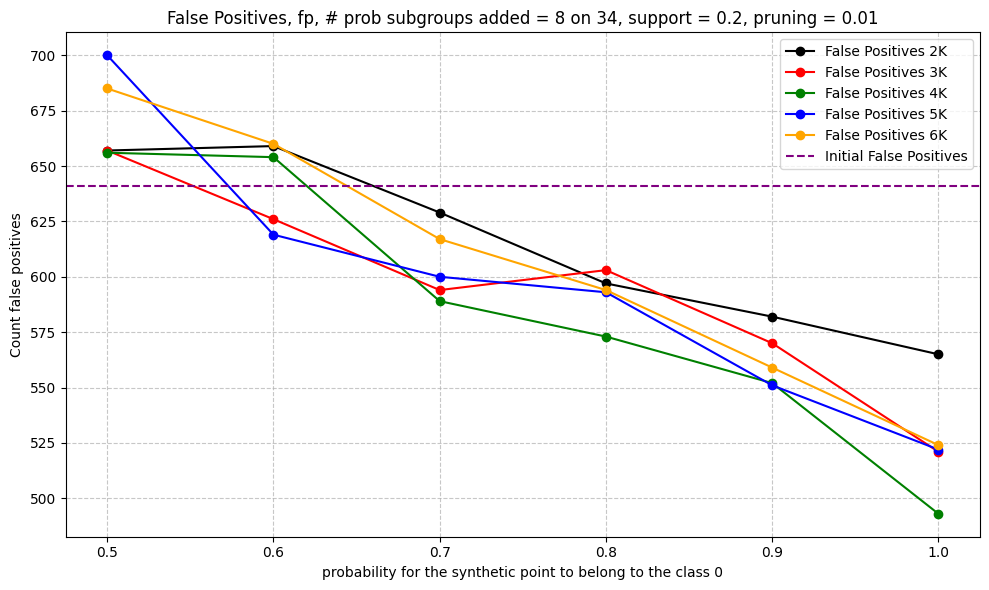

In [543]:
# Creazione del grafico
plt.figure(figsize=(10, 6))
p =[0.5, 0.6, 0.7, 0.8, 0.9, 1]
# Linea per i falsi positivi


plt.plot(p, falsi_positivi_2K_fp_5sub, marker='o', label='False Positives 2K', color='black')
plt.plot(p, falsi_positivi_3K_fp_5sub, marker='o', label='False Positives 3K', color='red')
plt.plot(p, falsi_positivi_4K_fp_5sub, marker='o', label='False Positives 4K', color='green')
plt.plot(p, falsi_positivi_5K_fp_5sub, marker='o', label='False Positives 5K', color='blue')
plt.plot(p, falsi_positivi_6K_fp_5sub, marker='o', label='False Positives 6K', color='orange')
#plt.plot(p, falsi_positivi_7K_fp_5sub, marker='o', label='False Positives 7K', color='red')


plt.axhline(y=falsi_positivi_5K_fp_5sub_before, color='purple', linestyle='--', label='Initial False Positives')

# Etichette e titolo
plt.xlabel('probability for the synthetic point to belong to the class 0')
plt.ylabel('Count false positives')
plt.title(f'False Positives, fp, # prob subgroups added = {K} on {filtered_instances}, support = {min_sup}, pruning = 0.01')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.yticks(range(500, 701, 25))

# Mostra il grafico
plt.tight_layout()
plt.show()

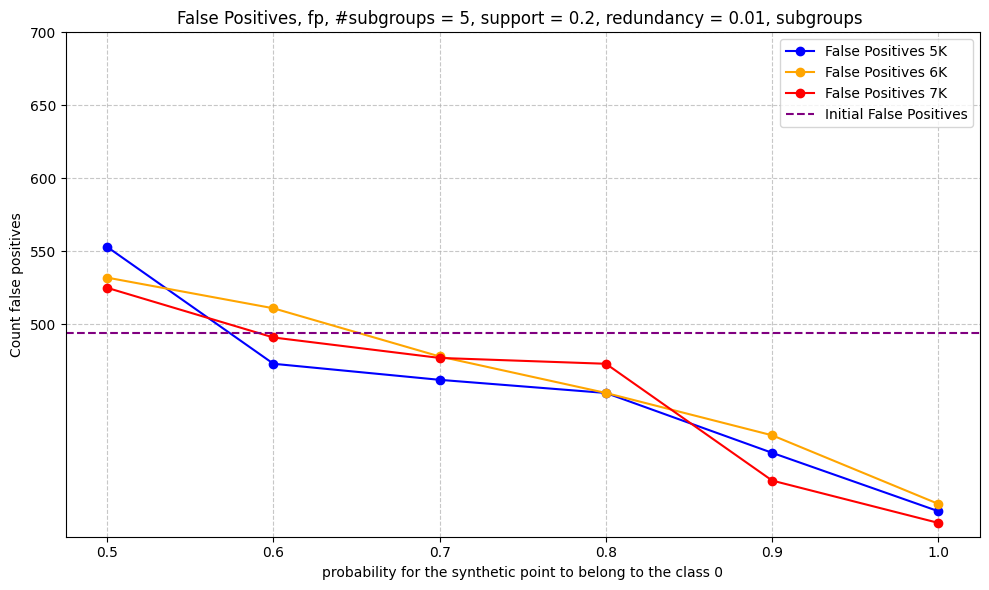

In [544]:
# Creazione del grafico
plt.figure(figsize=(10, 6))
p =[0.5, 0.6, 0.7, 0.8, 0.9, 1]
# Linea per i falsi positivi

plt.plot(p, falsi_positivi_5K_fp_5sub_sub, marker='o', label='False Positives 5K ', color='blue')
plt.plot(p, falsi_positivi_6K_fp_5sub_sub, marker='o', label='False Positives 6K ', color='orange')
plt.plot(p, falsi_positivi_7K_fp_5sub_sub, marker='o', label='False Positives 7K ', color='red')


plt.axhline(y=falsi_positivi_5K_fp_5sub_sub_before, color='purple', linestyle='--', label='Initial False Positives')

# Etichette e titolo
plt.xlabel('probability for the synthetic point to belong to the class 0')
plt.ylabel('Count false positives')
plt.title('False Positives, fp, #subgroups = 5, support = 0.2, redundancy = 0.01, subgroups ')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.yticks(range(500, 701, 50))
# Mostra il grafico
plt.tight_layout()

plt.show()

Text(0.5, 1.0, 'Primo grafico§')

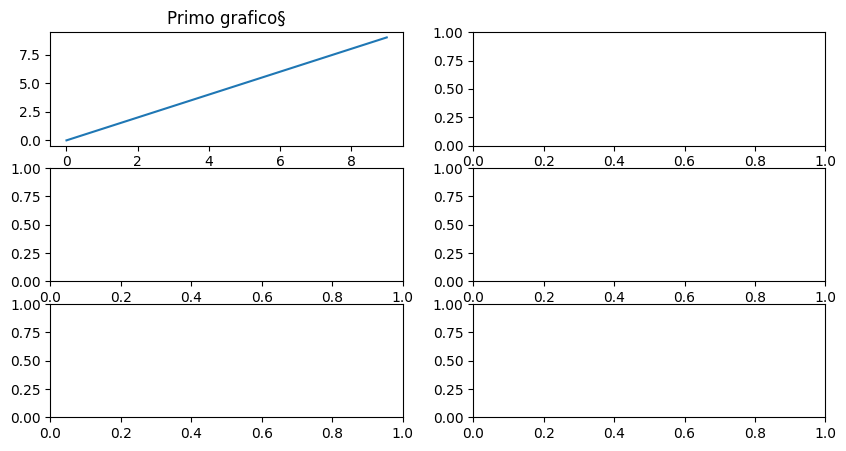

In [545]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 2, figsize=(10, 5))


ax[0, 0].plot(range(10), range(10))
ax[0,0].set_title("Primo grafico§")